In [3]:
# !pip install seaborn
# !pip install statsmodels

# !pip install numpy==1.23.5 mkl
# !pip install pmdarima==2.0.3

# !pip install category_encoders
# pip install -U category_encoders
# pip install -U "scikit-learn<1.6"

#!pip install numpy==1.26.4 scipy==1.12.0
#!pip uninstall pmdarima
#!pip install pmdarima 

#!pip install prophet

import pandas as pd
import numpy as  np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import Image
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) 

import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

import logging
logging.getLogger("cmdstanpy").setLevel(logging.WARNING)
logging.getLogger("cmdstanpy").setLevel(logging.ERROR)

**Problem Statement:**
    
In the competitive retail industry, the ability to predict future sales accurately is crucial for
operational and strategic planning. Product sales forecasting aims to estimate the number of
products a store will sell in the future, based on various influencing factors such as store type,
location, regional characteristics, promotional activities, and temporal variations (such as
holidays and seasons). This project focuses on developing a predictive model that uses
historical sales data from different stores to forecast sales for upcoming periods.

**Supply Chain Optimization**

1. Total Sales Forecasting:
    * Facilitates comprehensive ***production planning*** aligned with demand, enables bulk raw material procurement, reducing procurement costs & supports efficient allocation of manpower and utilities
    * Optimizes ***sales promotions*** by identifying sales spikes and drops
    * Assists in region-specific demand planning, enhances ***logistics and distribution management***
    * Improves ***inventory management*** by anticipating store-level demand and ensures ***optimal staffing*** and resource allocation
2. Impact of Holiday on sales
3. Impact of discount on sales

In [4]:
data = pd.read_csv(r"C:\Users\akash.bana\Desktop\Akash_backup\Akash\Scaler\Jobs\Data Scientist\Product sales forecasting\TRAIN.csv")
df = data.copy()
df.head(3)

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,#Order,Sales
0,T1000001,1,S1,L3,R1,2018-01-01,1,Yes,9,7011.84
1,T1000002,253,S4,L2,R1,2018-01-01,1,Yes,60,51789.12
2,T1000003,252,S3,L2,R1,2018-01-01,1,Yes,42,36868.20


**Data description:**

1. ID: Unique identifier for each record in the dataset.
2. Store_id: Unique identifier for each store.
3. Store_Type: Categorization of the store based on its type.
4. Location_Type: Classification of the store's location (e.g., urban, suburban).
5. Region_Code: Code representing the geographical region where the store is located.
6. Date: The specific date on which the data was recorded.
7. Holiday: Indicator of whether the date was a holiday (1: Yes, 0: No).
8. Discount: Indicates whether a discount was offered on the given date (Yes/No)
9. #Order: The number of orders received by the store on the specified day.
10. Sales: Total sales amount for the store on the given day.

# EDA

In [5]:
df.shape

(188340, 10)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188340 entries, 0 to 188339
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   ID             188340 non-null  object 
 1   Store_id       188340 non-null  int64  
 2   Store_Type     188340 non-null  object 
 3   Location_Type  188340 non-null  object 
 4   Region_Code    188340 non-null  object 
 5   Date           188340 non-null  object 
 6   Holiday        188340 non-null  int64  
 7   Discount       188340 non-null  object 
 8   #Order         188340 non-null  int64  
 9   Sales          188340 non-null  float64
dtypes: float64(1), int64(3), object(6)
memory usage: 14.4+ MB


In [7]:
df = df.rename(columns={'#Order':'orders_per_day','Sales':'sales_per_day'}) # columns re-named
df['Date'] = pd.to_datetime(df['Date']) # data type changed
df['Discount'] = df['Discount'].map({'Yes':1, 'No':0}) 

In [8]:
# understanding date column

start_date = df['Date'].min()
end_date = df['Date'].max()
num_days = end_date - start_date

complete_range = pd.date_range(start=start_date, end=end_date, freq='D')
missing_dates = set(complete_range) - set(df['Date'])

if not missing_dates:
    print(f"The time series has continuous dates from first to last, from ({start_date}) to ({end_date})")
    print(f"No. of days data is captured for: {num_days}")
else:
    print(f"There are missing dates: {sorted(missing_dates)}")

The time series has continuous dates from first to last, from (2018-01-01 00:00:00) to (2019-05-31 00:00:00)
No. of days data is captured for: 515 days 00:00:00


**Data Analysis**

In [9]:
df.head(2)

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,orders_per_day,sales_per_day
0,T1000001,1,S1,L3,R1,2018-01-01,1,1,9,7011.84
1,T1000002,253,S4,L2,R1,2018-01-01,1,1,60,51789.12


In [10]:
num = df['Store_id'].nunique() # no. of unique stores
print(f'No. of unique stores: {num}') 

No. of unique stores: 365


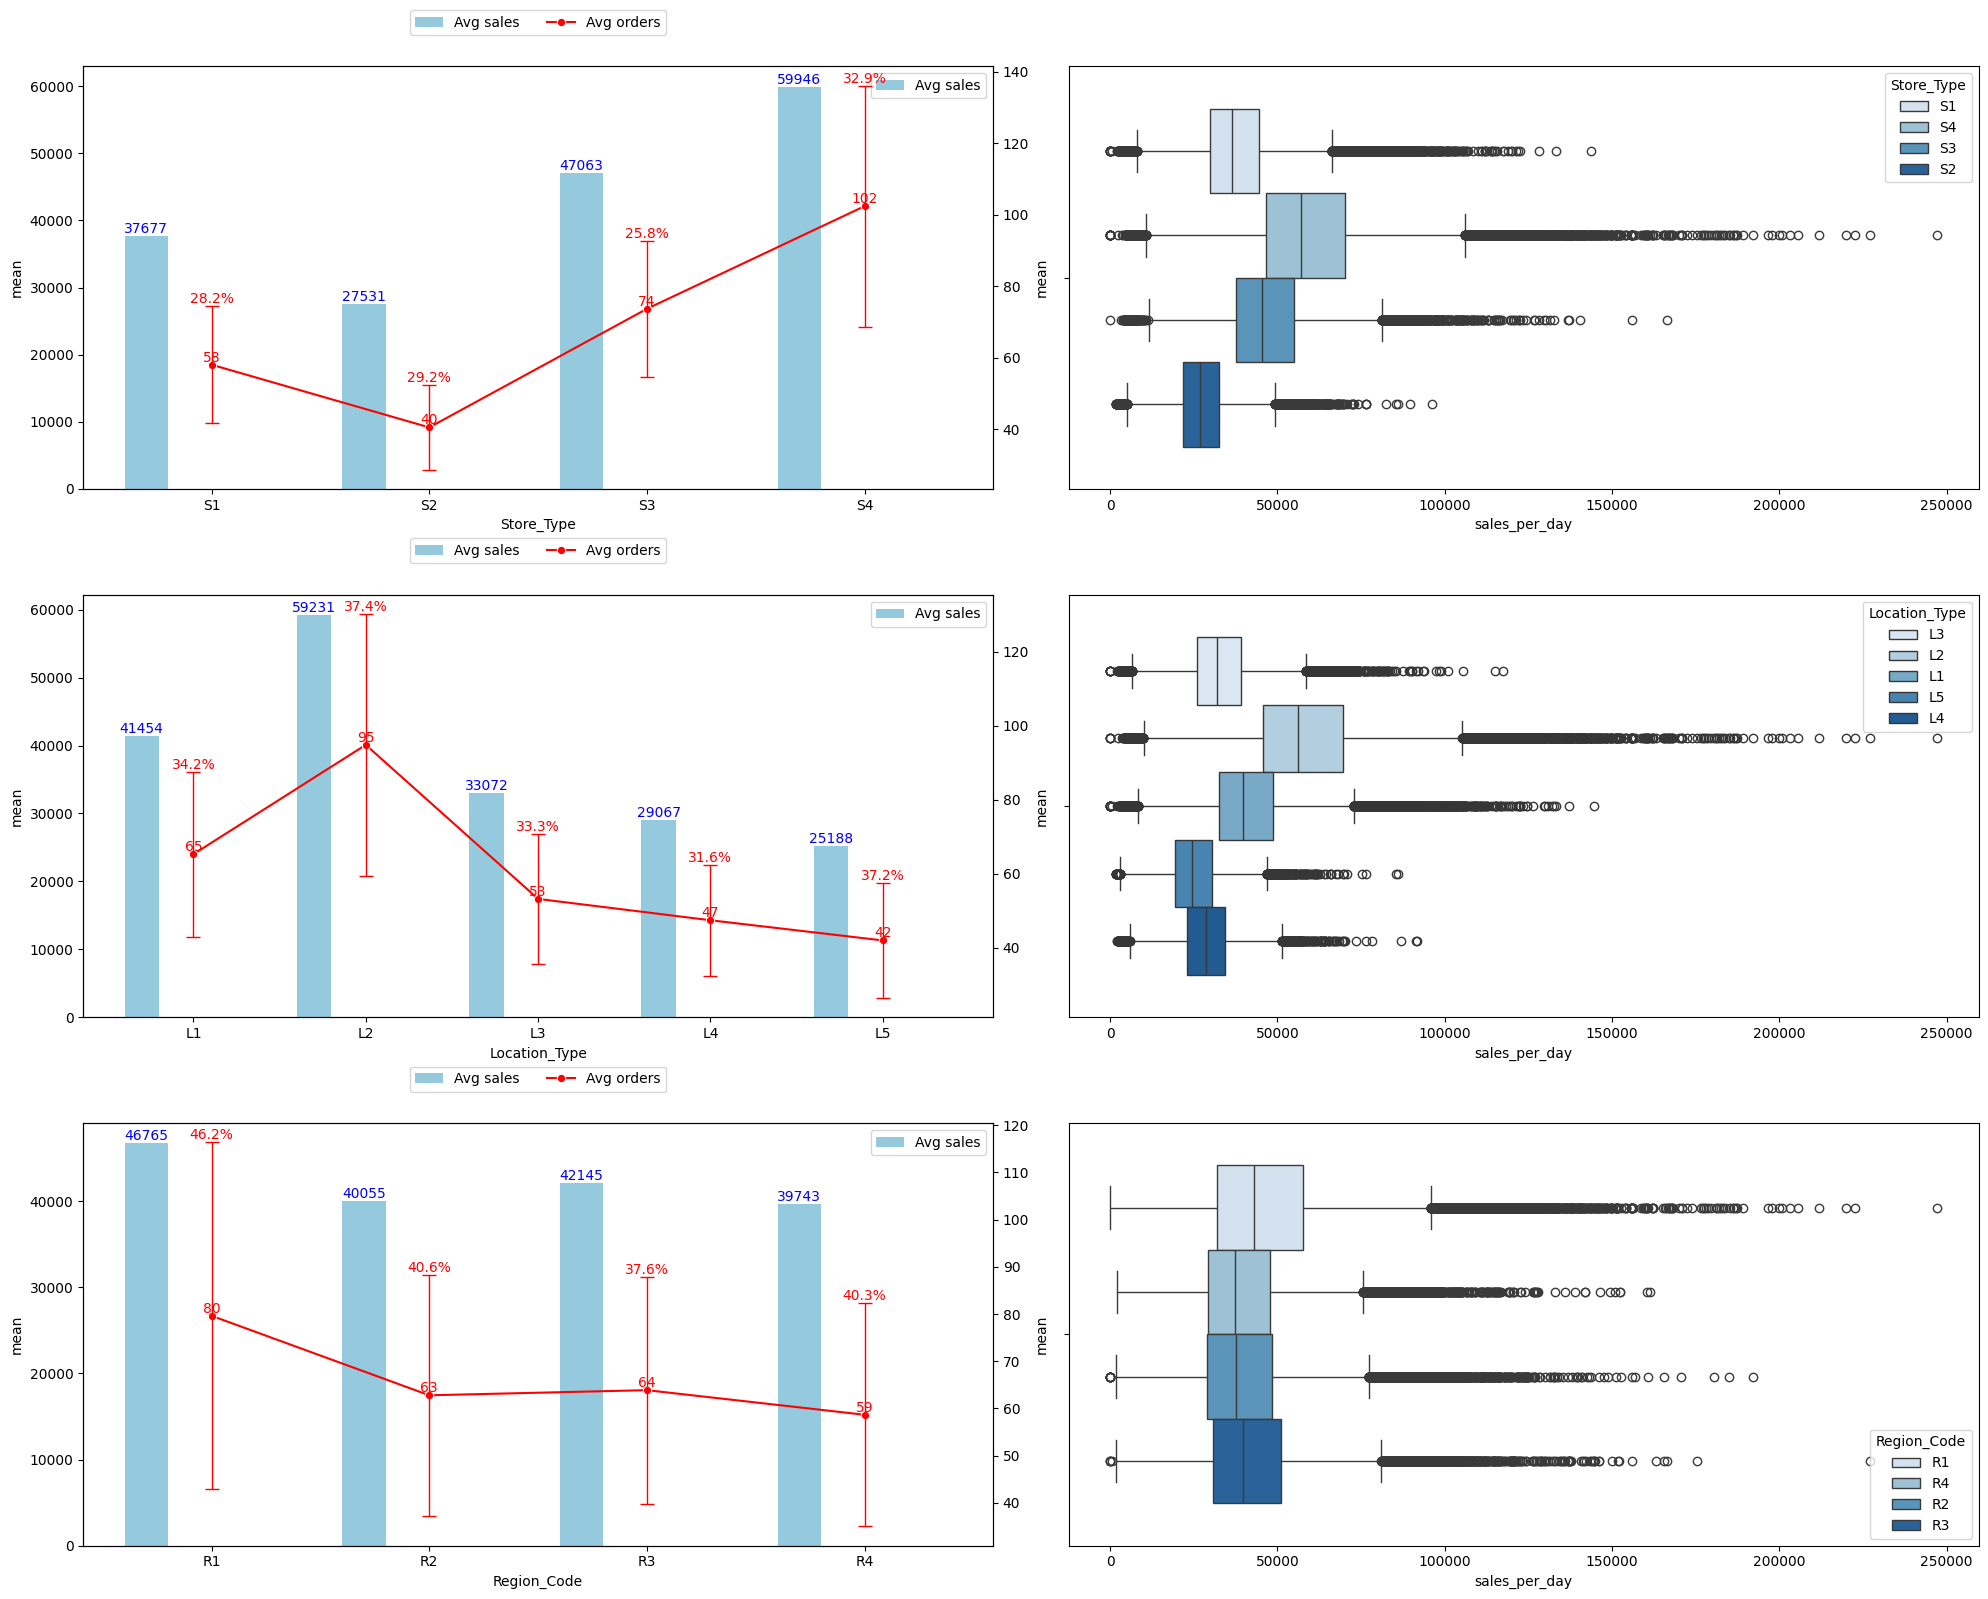

In [11]:
cols = ['Store_Type','Location_Type','Region_Code']

plt.figure(figsize=(20,16))

j = 1
for i in cols:
    da = df.groupby([i]).agg({'orders_per_day':['mean','std'], 'sales_per_day':['mean','std']}).reset_index()
    
    plt.subplot(3,2,j)

    ax1 = plt.gca() 
    ax1 = sns.barplot(x = da[i], y = da['sales_per_day']['mean'], color = 'skyblue', label = 'Avg sales') 
    for bar, value in zip(ax1.patches, da['sales_per_day']['mean']):
        bar.set_width(0.2)
        ax1.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{value:.0f}', 
                 ha='center', va='bottom', fontsize=10, color='blue')

    ax2 = ax1.twinx()
    sns.lineplot(x = da[i], y = da['orders_per_day']['mean'], ax = ax2, color = 'red', label = 'Avg orders', marker = 'o') 
    ax2.errorbar(da[i], da['orders_per_day']['mean'], yerr=da['orders_per_day']['std'],
                 fmt='none', ecolor='red', capsize=5, elinewidth=1)
    for x, mean, std in zip(da[i], da['orders_per_day']['mean'], da['orders_per_day']['std']):
        ax2.text(x, mean, f'{mean:.0f}', ha='center', va='bottom', fontsize=10, color='red') 
        percentage_change = (std / mean) * 100
        ax2.text(x, mean + std, f'{percentage_change:.1f}%', ha='center', va='bottom', fontsize=10, color='red')

    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels() 
    plt.legend(handles1 + handles2, labels1 + labels2, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2)

    plt.subplot(3,2,j+1) 
    sns.boxplot(x = df['sales_per_day'], hue = df[i], palette = 'Blues')
    
    j += 2

plt.tight_layout()
plt.show()

**Store Type:**

1. ***S4*** leads with the highest average sales (~59.9k) and orders/day (102), showing strong revenue and customer activity despite high variability
2. ***S3*** performs well with solid sales and order volume
3. ***S1*** has moderate sales but lower order efficiency
4. ***S2*** underperforms with the lowest sales and orders/day, though it's the most consistent

**Insight:**

1. ***S4*** is the most profitable but volatile. ***S2*** shows stability but lacks performance

**Location Type:**

1. ***L2*** leads with the highest avg sales (~59.2k) and orders/day (95), showing strong performance
2. ***L1 & L3*** have moderate sales and order volumes
3. ***L4 & L5*** show low sales and order volume

**Insight:**

1. ***L2*** is the top-performing location. ***L5*** and ***L4*** underperform and need attention

**Region Type:**

1. ***R1*** has the highest avg sales (~46.8k) and high orders/day (69), but also the highest variability (46.2%)
2. ***R2, R3, R4*** have similar avg sales (~40k–42k) with ***R4*** having the lowest order volume (57/day)
3. ***R3*** shows relatively better order efficiency (37.6%)

**Insight:**

1. ***R1*** is the top-selling but most volatile region. ***R4*** lags in order volume. All regions show similar sales but vary in efficiency and consistency

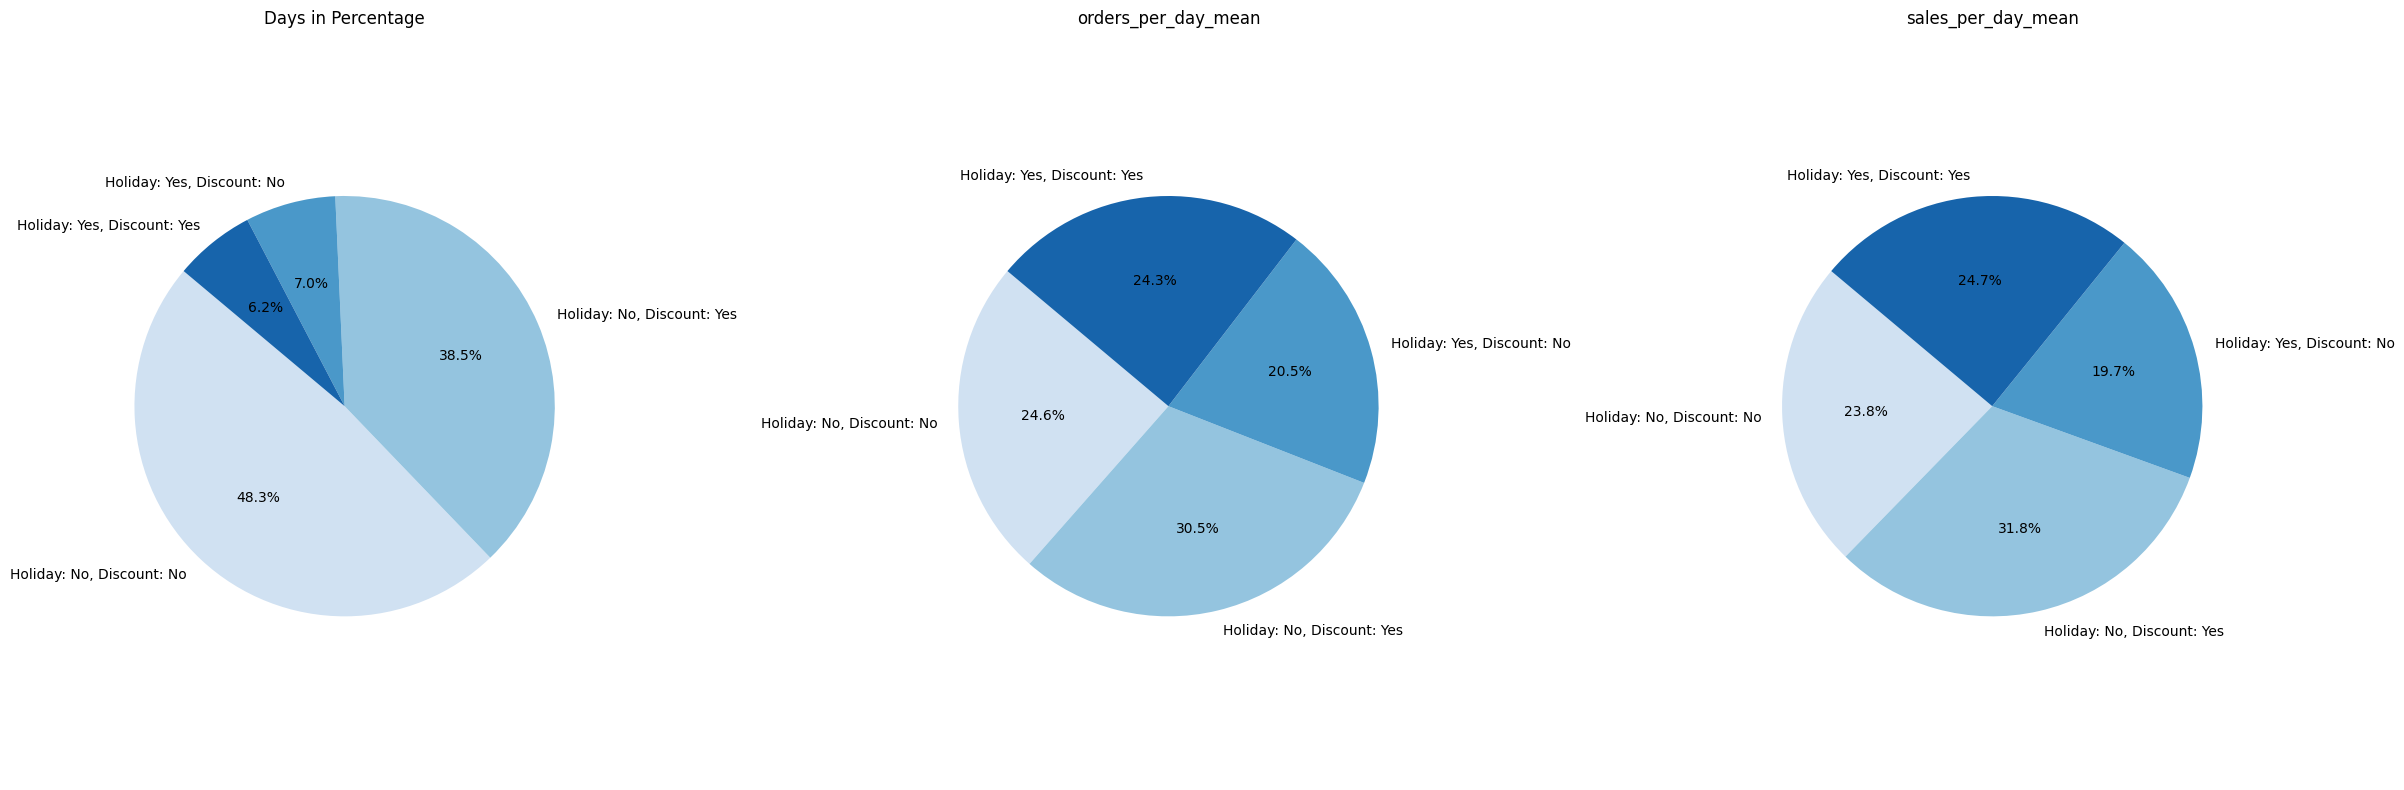

In [12]:
da = df.groupby(['Holiday','Discount']).agg({'orders_per_day':['mean','std','count'], 'sales_per_day':['mean','std']}).reset_index()
da.columns = ['_'.join(col) for col in da.columns]

labels = ['Holiday: No, Discount: No', 'Holiday: No, Discount: Yes', 'Holiday: Yes, Discount: No', 'Holiday: Yes, Discount: Yes'] 
colors = sns.color_palette('Blues', 4) 
cols = ['orders_per_day_count','orders_per_day_mean','sales_per_day_mean']

# Plot Configuration
plt.rcParams['figure.figsize'] = (24, 8)

# oop to Plot
for j, col in enumerate(cols, 1):
    sizes = da[col]
    plt.subplot(1, 3, j)
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
    plt.axis('equal')
    plt.title('Days in Percentage' if j == 1 else col) 

plt.tight_layout()
plt.show() 

1. **Day Distribution:** Majority of days (48.3%) had no holiday, no discount. Only 6.2% of days had both holiday and discount
2. **Order Volume:** Highest orders on non-holiday discount days (30.5%). Holiday no-discount days had the lowest order share (20.5%)
3. **Sales Volume:** Highest sales on non-holiday discount days (31.8%). Followed by holiday + discount days (24.7%)

**Insight:**

1. Discounts strongly boost both orders and sales, regardless of holidays
2. Holidays alone do not guarantee higher sales or orders—discounts are key

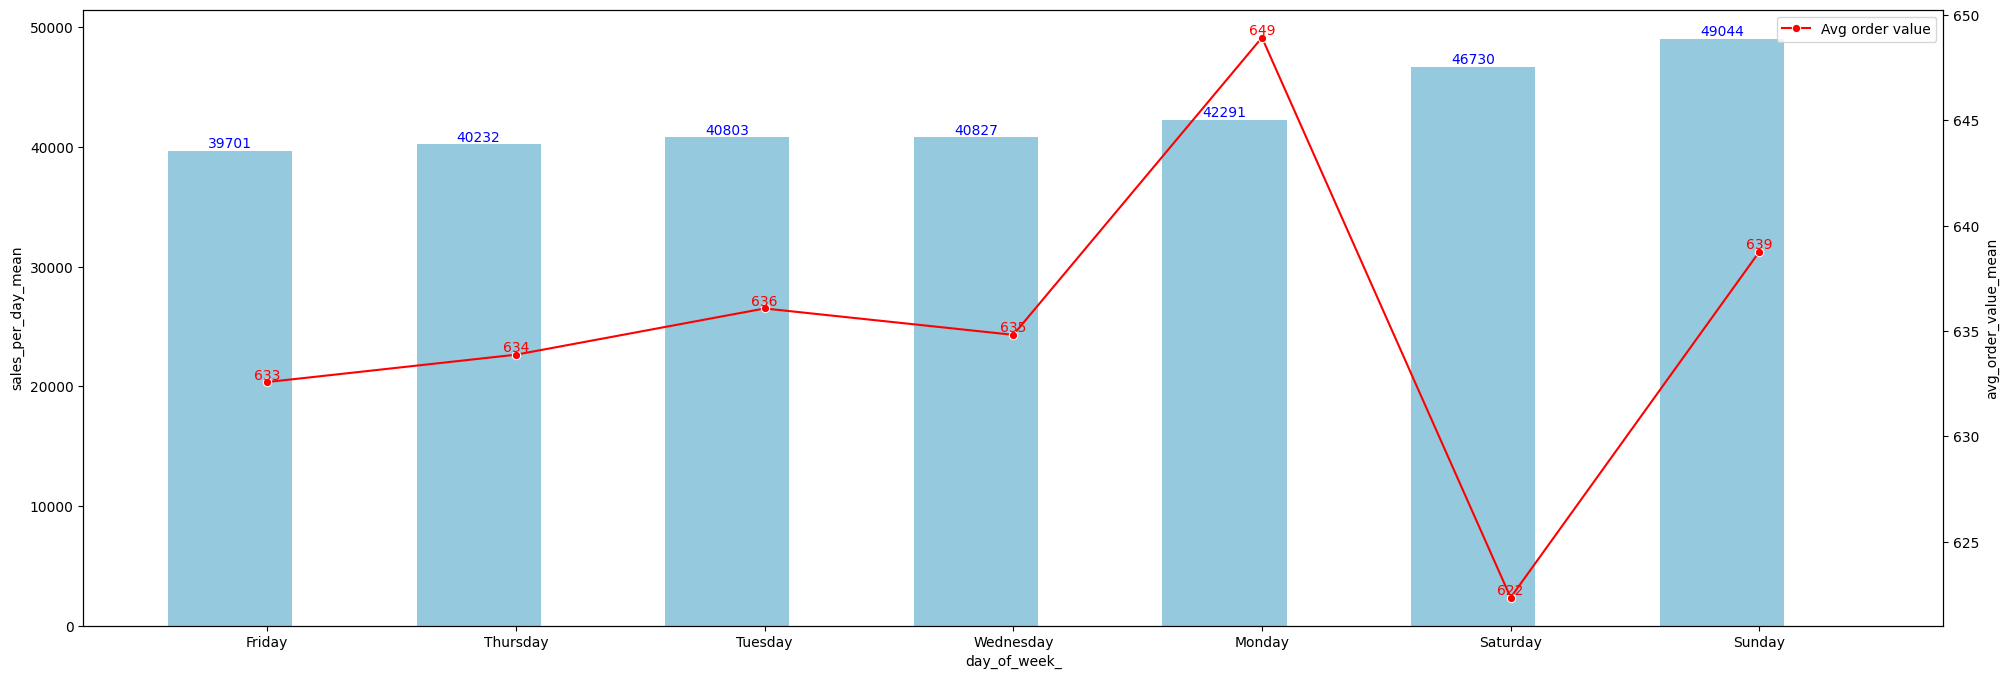

In [13]:
df['day_of_week'] = df['Date'].dt.day_name() # day of the week
df['quarter'] = df['Date'].dt.quarter # quarter
df['month'] = df['Date'].dt.month # month
df['day'] = df['Date'].dt.day # day

df['avg_order_value'] = round(df['sales_per_day']/df['orders_per_day']) # avg value of each order

da = df.groupby(['day_of_week']).agg({'orders_per_day':['mean','std'], 'sales_per_day':['mean','std'], 'avg_order_value':['mean','std']}).reset_index()
da.columns = ['_'.join(col) for col in da.columns]
da = da.sort_values(by = 'sales_per_day_mean') # sort in ascending by average sales

ax1 = plt.gca()
ax1 = sns.barplot(x = da['day_of_week_'], y = da['sales_per_day_mean'], color = 'skyblue')
for bar, value in zip(ax1.patches, da['sales_per_day_mean']): 
    bar.set_width(0.5)
    ax1.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{value:.0f}', 
                 ha='center', va='bottom', fontsize=10, color='blue') 

ax2 = ax1.twinx()
sns.lineplot(x = da['day_of_week_'], y = da['avg_order_value_mean'], ax = ax2, marker = 'o', color = 'red', label = 'Avg order value')
plt.legend()
for x,mean in zip(da['day_of_week_'], da['avg_order_value_mean']):
    ax2.text(x, mean, f'{mean:.0f}', ha='center', va='bottom', fontsize=10, color='red')

plt.show()

**Key Findings:**

1. Sunday had the highest average sales (~₹49,044) and strong average order value (₹639)
2. Saturday followed with ~₹46,730 in sales, but had the lowest avg order value (₹623), indicating high order volume
3. Monday had the highest average order value (₹649), despite lower total sales than the weekend
4. Weekdays (Tue–Fri) showed relatively stable sales (₹39k–₹41k) and avg order values (₹631–₹636)

**Insights:**

1. Weekends drive higher revenue, likely due to more consumer activity
2. Monday shows fewer but higher-value orders—suggesting potential for premium offerings

**Recommendation:**

1. Leverage weekends for promotions to maximize volume
2. Explore targeted campaigns on Mondays for high-value customers

In [14]:
# Impact of holidays & discounts

# statistical test to check if the difference is significant
import scipy.stats as stats

# Ho: no significant difference in means
# Ha: significant difference in means

cols = ['Holiday','Discount']
for col in cols:
    t_stat, p_val = stats.ttest_ind(df[df[col]==1]['sales_per_day'], df[df[col]==0]['sales_per_day']) 
    alpha = 0.05
    if p_val < alpha:
        print(f"Reject the null hypothesis: Significant difference in average sales --> [{col}]") 
    else:
        print(f"Fail to reject the null hypothesis: No significant difference --> [{col}]") 

Reject the null hypothesis: Significant difference in average sales --> [Holiday]
Reject the null hypothesis: Significant difference in average sales --> [Discount]


# Data Pre-Processing

In [15]:
df.head(2)

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,orders_per_day,sales_per_day,day_of_week,quarter,month,day,avg_order_value
0,T1000001,1,S1,L3,R1,2018-01-01,1,1,9,7011.84,Monday,1,1,1,779.0
1,T1000002,253,S4,L2,R1,2018-01-01,1,1,60,51789.12,Monday,1,1,1,863.0


**Missing values**

In [16]:
# missing values

df.isna().sum()

ID                  0
Store_id            0
Store_Type          0
Location_Type       0
Region_Code         0
Date                0
Holiday             0
Discount            0
orders_per_day      0
sales_per_day       0
day_of_week         0
quarter             0
month               0
day                 0
avg_order_value    19
dtype: int64

In [17]:
df[df.isna().any(axis=1)]['orders_per_day'].unique(), df[df.isna().any(axis=1)]['sales_per_day'].unique() # no sales on these days

(array([0], dtype=int64), array([0.]))

In [18]:
df = df[df['sales_per_day'] != 0] 

* Rows with 0 sales are assumed as stores were closed since orders were 0 and therefore will be dropped

**Outliers**

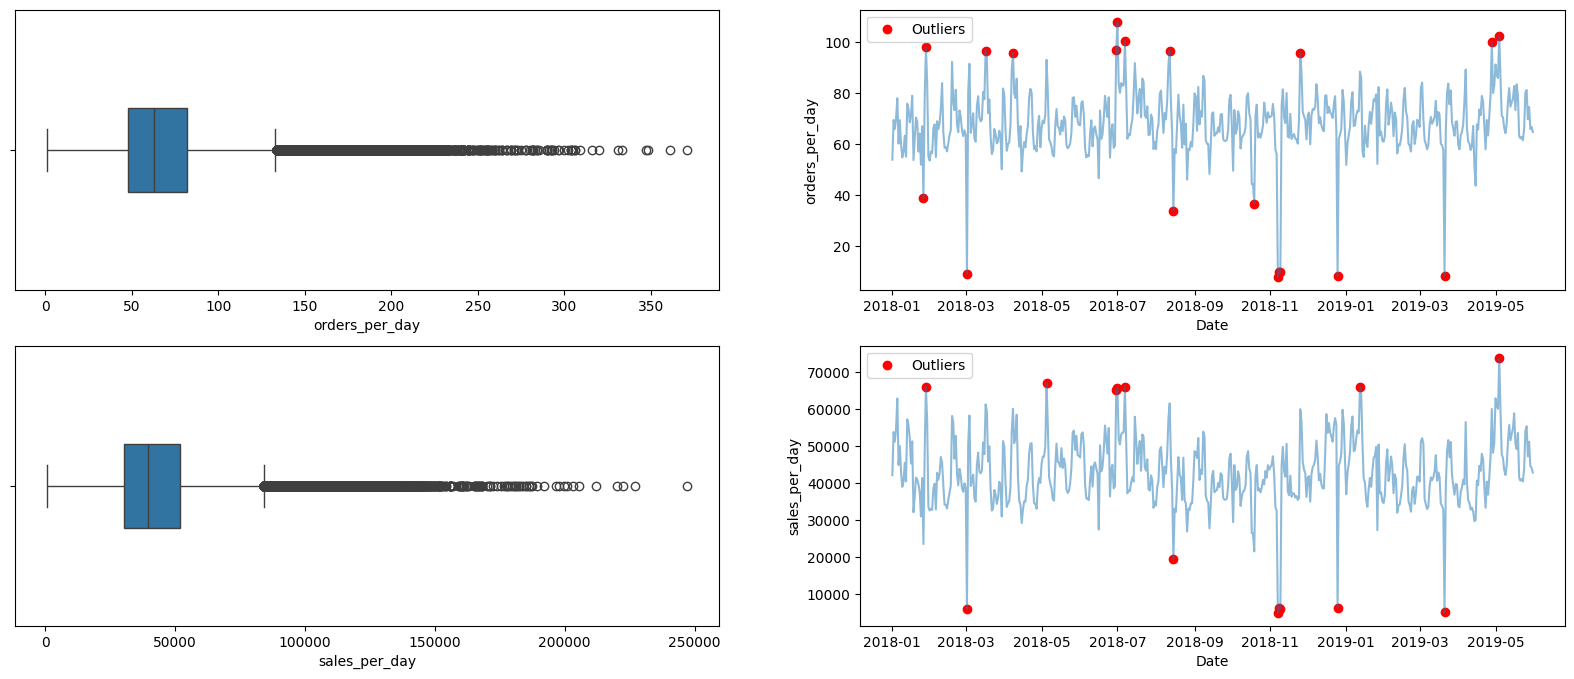

In [19]:
# outliers

def outlr(arry):
    q1 = np.percentile(arry, 25)
    q3 = np.percentile(arry, 75)
    iqr = q3 - q1
    lower_bound = q1 - (1.5*iqr)
    upper_bound = q3 + (1.5*iqr) 
    return lower_bound, upper_bound

plt.figure(figsize = (20,8))

cols = ['orders_per_day','sales_per_day'] 
j = 1
for col in cols:
    plt.subplot(2,2,j)
    sns.boxplot(x = df[col], width = 0.3)

    df_total = df.groupby(['Date'])[col].mean().reset_index()
    plt.subplot(2,2,j+1)
    sns.lineplot(x = df_total['Date'], y = df_total[col], alpha = 0.5) 
    
    lb, ub = outlr(df_total[col]) 
    outliers = (df_total[col] < lb )| (df_total[col] > ub)  
    plt.scatter(df_total['Date'][outliers], df_total[col][outliers], color='red', label='Outliers')
    plt.legend() 

    j += 2

plt.show()

1. Red dots represent outliers in the line plots, which are identified using ***IQR***
2. Outliers could be because of various reasons like ***wrong entry, higher sales due to festivals, etc***

**Assumptions:**
* Spikes & drops in sales are supported by no. of orders placed, so I am assuming that due to some external event, these spikes & drops in sales are noticed

# Model Building

**Time Series Characteristics**

Any time series may consist of the following components: ***Base Level + Trend + Seasonality + Error***

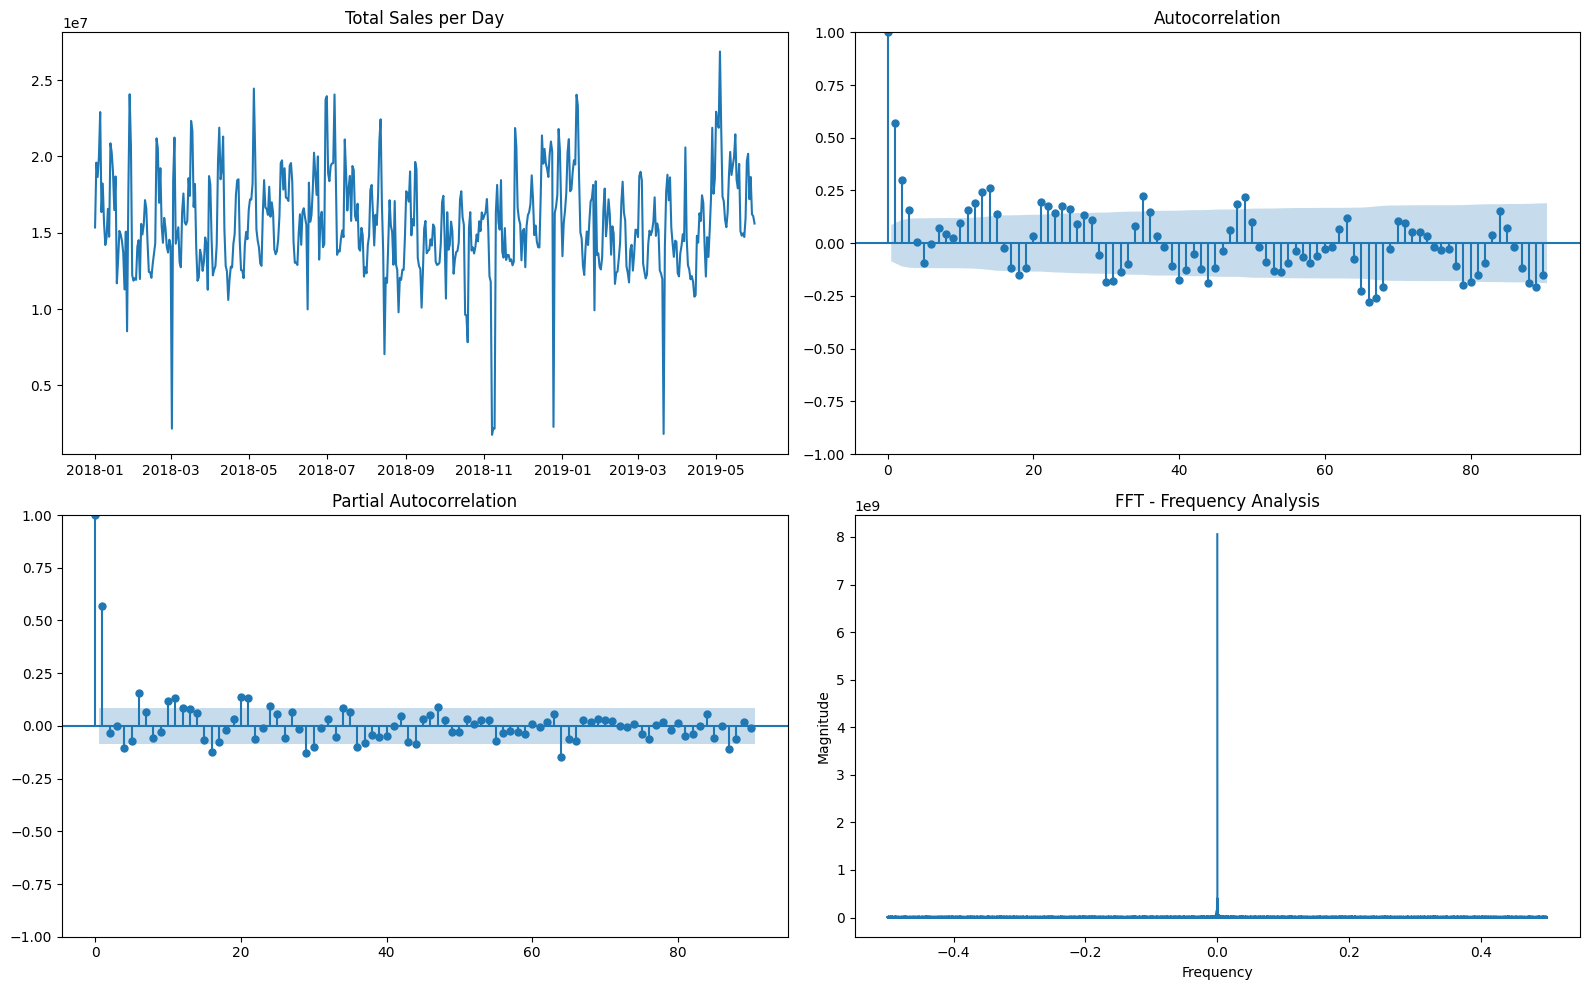

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np

plt.rcParams['figure.figsize'] = (16, 10)

total_daily_sales = df.groupby(['Date'])['sales_per_day'].sum()

# Create a 2x2 plot
fig, ax = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: Total Sales per Day
ax[0, 0].plot(total_daily_sales.index, total_daily_sales.values)
ax[0, 0].set_title('Total Sales per Day')

# Plot 2: Autocorrelation Plot
plot_acf(total_daily_sales, lags=90, ax=ax[0, 1])
ax[0, 1].set_title('Autocorrelation')

# Plot 3: Partial Autocorrelation Plot
plot_pacf(total_daily_sales, lags=90, ax=ax[1, 0])
ax[1, 0].set_title('Partial Autocorrelation')

# Perform the Fast Fourier Transform (FFT)
fft_vals = np.fft.fft(df['sales_per_day'])
frequencies = np.fft.fftfreq(len(fft_vals))

# Plot 4: FFT - Frequency Analysis
ax[1, 1].plot(frequencies, np.abs(fft_vals))
ax[1, 1].set_title('FFT - Frequency Analysis')
ax[1, 1].set_xlabel('Frequency')
ax[1, 1].set_ylabel('Magnitude')

plt.tight_layout()
plt.show()


**ACF Plot:** Autocorrelation measures the correlation between a time series and its lagged values

1. The plot shows a significant spike at lag 1, which usually indicates strong autocorrelation and possible short-term persistence in the data
2. Gradual decay in the ACF often suggests a non-stationary series, possibly with a trend or seasonality

**PACF Plot:** Partial Autocorrelation measures the direct effect of a lag on the series by removing the influence of intermediate lags

1. The strong spike at lag 1 is also visible in the PACF plot, which is typical for autoregressive (AR) processes
2. A sudden drop-off after lag 1, followed by values within the confidence interval, indicates a potential ***AR(1)*** process

**FFT**
1. There are no other significant peaks at non-zero frequencies, suggesting the ***absence of clear seasonal or cyclical patterns***. This means this time series data likely lacks strong periodicity

**Stationarity**

**ADF Test (Augmented Dickey-Fuller):**

The ADF test checks if a time series is stationary, meaning its statistical properties (mean, variance) do not change over time—critical for models like ARIMA.

***Null Hypothesis (H₀):*** Series has a unit root (non-stationary)   |   ***Alternative Hypothesis (H₁):*** Series is stationary

A ***p-value < 0.05*** → reject H₀ → stationary series

***Insight:*** Helps determine if differencing is needed to make the series suitable for modeling

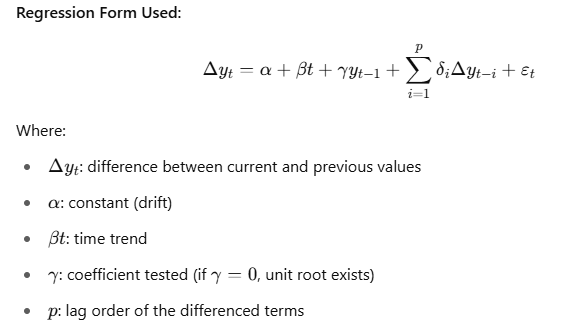

In [21]:
# A stationary series is one where the values of the series is not a function of time
# Hence the statistical properties of the series like mean, variance and autocorrelation are constant over time. 
# This makes it easier for models to detect patterns and make accurate predictions

from statsmodels.tsa.stattools import adfuller 
# Ho: data is not stationary
# Ha: data is stationary

result = adfuller(total_daily_sales) 
print(f'ADF statistic:{result[0]}')
print(f'p value:{result[1]}') 

if result[1] < 0.05:
    print('Reject null hypothesis, Data is stationary')
else:
    print('Data is not stationary') 

ADF statistic:-3.524207906563324
p value:0.007386718711362262
Reject null hypothesis, Data is stationary


**Sales Forecasting**

Sales is a function of following factors - ***F(Store id x Time x Day of the week x Holiday x Discount)***

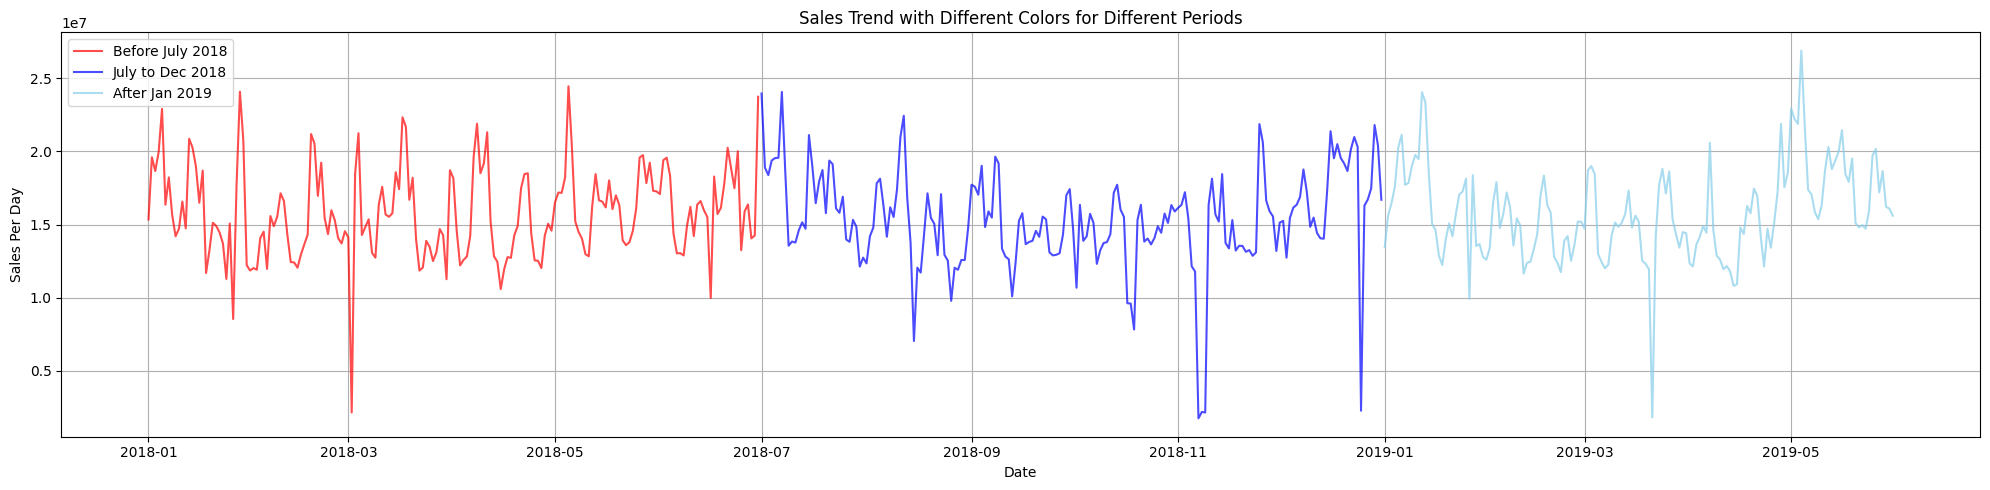

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Grouping and summing the sales per day
total_daily_sales = df.groupby('Date')['sales_per_day'].sum().reset_index()

# Defining color and label mappings
date_ranges = [
    (total_daily_sales['Date'] < '2018-07-01', 'red', 'Before July 2018'),
    ((total_daily_sales['Date'] >= '2018-07-01') & (total_daily_sales['Date'] < '2019-01-01'), 'blue', 'July to Dec 2018'),
    (total_daily_sales['Date'] >= '2019-01-01', 'skyblue', 'After Jan 2019')
]

# Plotting using a loop
plt.figure(figsize=(20, 5))
for condition, color, label in date_ranges:
    sns.lineplot(x='Date', y='sales_per_day', data=total_daily_sales[condition], color=color, label=label, alpha = 0.7)

# Customizing the plot
plt.xlabel('Date')
plt.ylabel('Sales Per Day')
plt.title('Sales Trend with Different Colors for Different Periods')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

## SARIMAX

**SARIMAX (Seasonal AutoRegressive Integrated Moving Average with eXogenous variables)**

SARIMAX is an extension of the ARIMA model that:

1. Handles seasonality
2. Supports exogenous variables (external predictors)

It combines: ***AR (AutoRegressive)***: past values + ***I (Integrated)***: differencing to remove trend + ***MA (Moving Average)***: past forecast errors + ***S (Seasonal)***: seasonal patterns + ***X (eXogenous)***: external regressors like holidays, promotions, weather, etc

                                                SARIMAX(p,d,q)(P,D,Q,s)
Where: ***p,d,q: ARIMA terms | P,D,Q: seasonal ARIMA terms | s: length of seasonality (e.g., 12 for monthly data with yearly seasonality)***

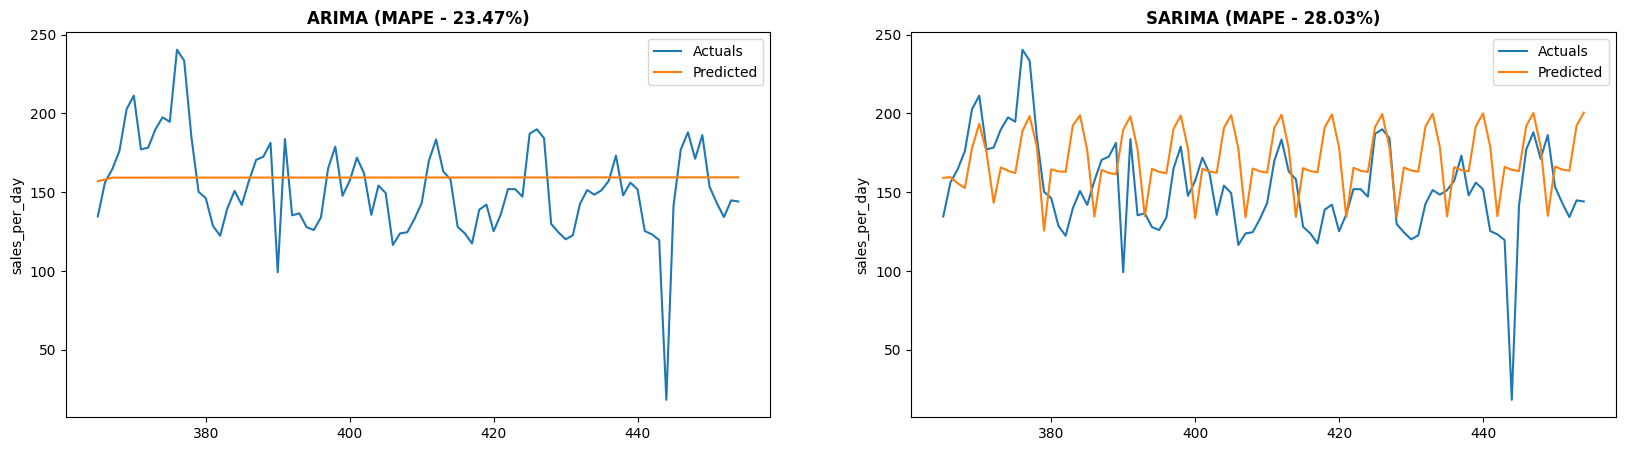

In [23]:
# ARIMA
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error 

# splitting the data 
df_total = df.groupby('Date')['sales_per_day'].sum().reset_index() 
df_total_train = df_total[df_total['Date'] < '2019-1-1'].copy() # first 12 months / 1 year 
df_total_val = df_total[(df_total['Date'] >= '2019-1-1')&(df_total['Date'] < '2019-4-1')].copy() # from month 13 to 15
df_total_test = df_total[df_total['Date'] >= '2019-4-1'].copy() # last 2 months of the data

plt.figure(figsize=(20,5))

p,d,q,P,D,Q,s = 1,0,3,0,0,0,0  
model_arima = SARIMAX(df_total_train['sales_per_day'], order = (p,d,q), seasonal_order = (P,D,Q,s), 
                enforce_stationarity = False, enforce_invertibility = False).fit()
val_pred_arima = model_arima.forecast(steps = df_total_val.shape[0]) 
mape_arima = round(mean_absolute_percentage_error(df_total_val['sales_per_day'], val_pred_arima)*100,2) 
#print(f'MAPE ARIMA: {mape_arima}%') 
plt.subplot(1,2,1)
plt.title(f'ARIMA (MAPE - {mape_arima}%)', fontweight='bold')
sns.lineplot(df_total_val['sales_per_day']/100000, label = 'Actuals')  # converted to lakhs
sns.lineplot(val_pred_arima/100000, label = 'Predicted') # converted to lakhs

p,d,q,P,D,Q,s = 1,0,0,3,0,1,7 
model_sarima = SARIMAX(df_total_train['sales_per_day'], order = (p,d,q), seasonal_order = (P,D,Q,s), 
                enforce_stationarity = False, enforce_invertibility = False).fit()
val_pred_sarima = model_sarima.forecast(steps = df_total_val.shape[0]) 
mape_sarima = round(mean_absolute_percentage_error(df_total_val['sales_per_day'], val_pred_sarima)*100,2) 
#print(f'MAPE SARIMA: {mape_sarima}%') 
plt.subplot(1,2,2)
plt.title(f'SARIMA (MAPE - {mape_sarima}%)', fontweight='bold')
sns.lineplot(df_total_val['sales_per_day']/100000, label = 'Actuals')  # converted to lakhs
sns.lineplot(val_pred_sarima/100000, label = 'Predicted') # converted to lakhs 

plt.show()

**Validation MAPE:**

ARIMA ---> ***23.4%***   | SARIMA ---> ***28.3%***

Data is ***stationary with no strong seasonality*** with multivariate features like ***holidays, discounts***, etc. Therefore, I will use ***SARIMAX*** directly as ***ARIMA*** models are struggling which do not capture the impact of exog variables

**Exog Impact**

In [24]:
# splitting the data 
df_train = df[df['Date'] < '2019-1-1'].copy() # first 12 months / 1 year 
df_val = df[(df['Date'] >= '2019-1-1')&(df['Date'] < '2019-4-1')].copy() # from month 13 to 15
df_test = df[df['Date'] >= '2019-4-1'].copy() # last 2 months of the data

**Variance in Daily/Monthly/Quarterly Sales**

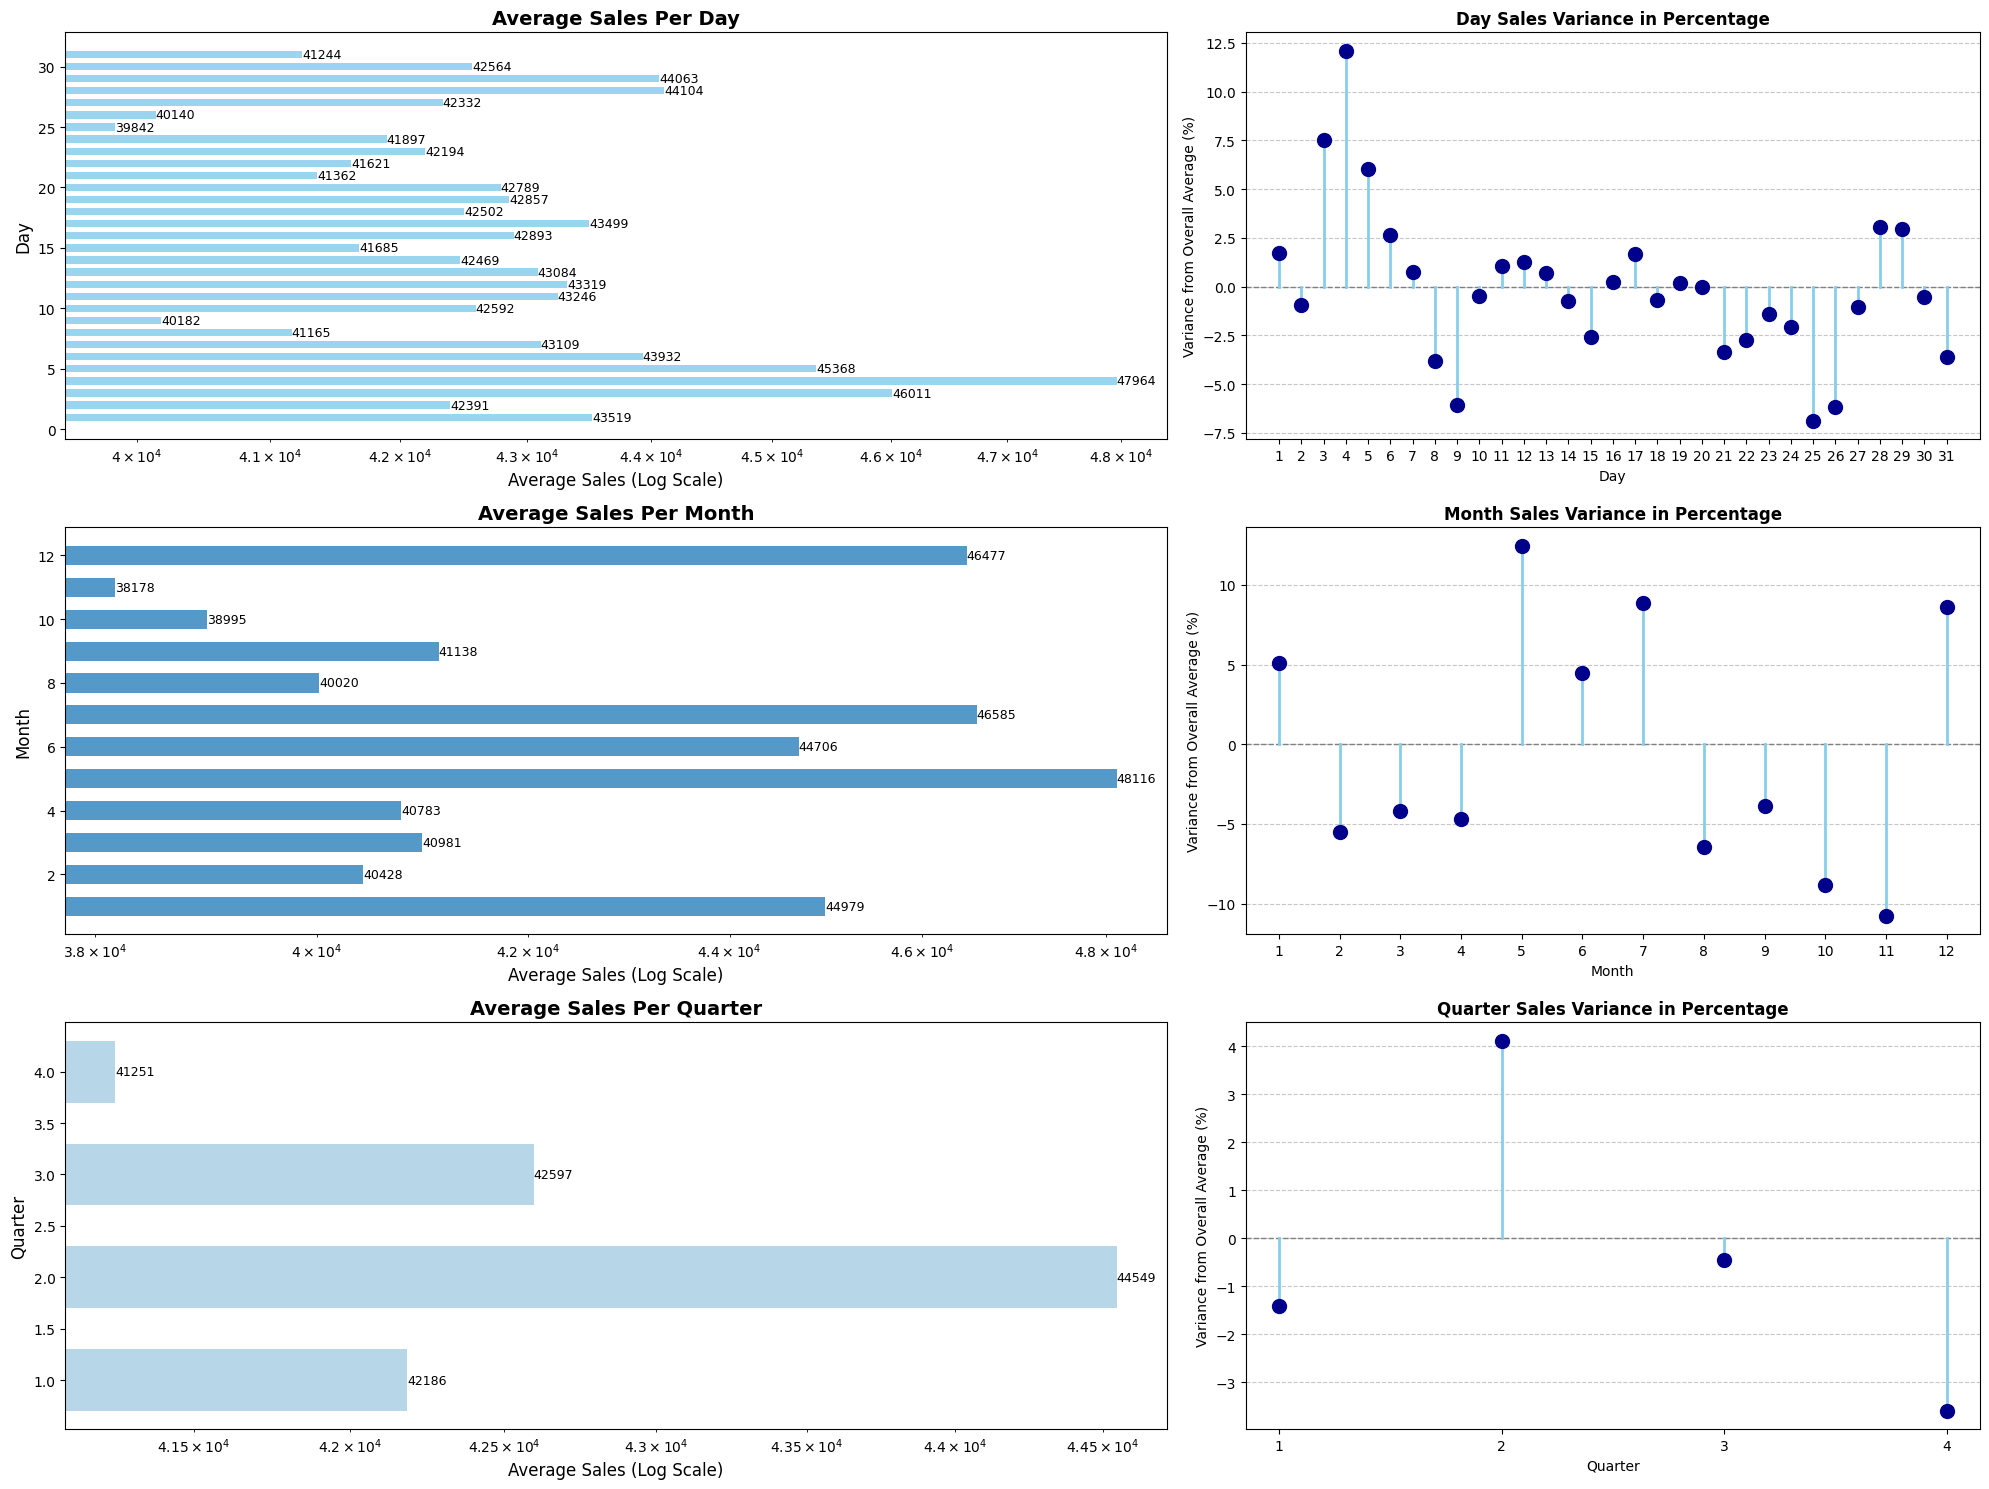

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(3, 2, figsize=(20, 15), gridspec_kw={'width_ratios': [3, 2]})

# Use Seaborn Blues palette
colors = ['skyblue', sns.color_palette("Blues_r", n_colors=2)[0], sns.color_palette("Blues_r", n_colors=2)[1]]
cols = ['day', 'month', 'quarter']

total_avg_sales = df['sales_per_day'].mean().round(2)

for j, col in enumerate(cols):
    avg_sales = df.groupby(col)['sales_per_day'].mean()

    # Left Side Plot (Bar Plot with Log Scale)
    bar_height = 0.6
    bars = axs[j, 0].barh(avg_sales.index, avg_sales.values, color=colors[j], alpha=0.85, height=bar_height)
    
    # Add value labels
    for bar in bars:
        xval = bar.get_width()
        axs[j, 0].text(xval, bar.get_y() + bar_height / 2, f'{xval:.0f}', 
                        ha='left', va='center', fontsize=9, color='black')

    axs[j, 0].set_title(f'Average Sales Per {col.capitalize()}', fontsize=14, fontweight='bold') 
    axs[j, 0].set_ylabel(f'{col.capitalize()}', fontsize=12)
    axs[j, 0].set_xlabel('Average Sales (Log Scale)', fontsize=12)
    axs[j, 0].grid(True, axis='x', linestyle='--', alpha=0.7)
    
    # Apply Log Scale for better visibility
    axs[j, 0].set_xscale('log')

    # Right Side Plot (Variance Plot)
    df_col = df.groupby([col])['sales_per_day'].mean().round(2).reset_index()
    df_col['variance_percentage'] = ((df_col['sales_per_day'] - total_avg_sales) / total_avg_sales) * 100

    axs[j, 1].axhline(0, color='grey', linestyle='--', linewidth=1)
    
    for i, row in df_col.iterrows():
        axs[j, 1].plot([row[col], row[col]], [0, row['variance_percentage']], color='skyblue', linewidth=2) 
        axs[j, 1].scatter(row[col], row['variance_percentage'], color='darkblue', s=100, zorder=3)
    
    axs[j, 1].set_xticks(df_col[col])
    axs[j, 1].set_xlabel(f'{col.capitalize()}')
    axs[j, 1].set_ylabel('Variance from Overall Average (%)')
    axs[j, 1].set_title(f'{col.capitalize()} Sales Variance in Percentage', fontweight='bold')
    axs[j, 1].grid(axis='y', linestyle='--', alpha=0.7) 

plt.tight_layout()
plt.show()


**Right plot** ---> It indicates variance in % of sales from overall average sales

**Day Sales:**

1. Days ***3, 4 & 5*** show positive deviations up to ***+12%***, indicating key high-performing days
2. Days beyond ***20*** i.e during month end, sales drop up to ***-6%***, suggesting underperformance

**Monthly Sales:**

1. ***May*** and ***December*** showed a ***+12% and +9%*** rise respectively, indicating seasonal demand spikes
2. ***October*** and ***November*** dropped by ***-9% to -11%***, signaling potential seasonal dips

**Quarter Sales:**

1. ***Q2*** emerged as the strongest performer with a ***+4%*** variance, indicating favorable sales conditions during this period
2. ***Q4*** showed the sharpest drop ***(-3.5%)***, which could hint at demand saturation or operational bottlenecks

In [26]:
# Feature Engineering

# months with higher sales than global average
months = [1,5,6,7,12]  
df_train['high_sales_month'] = np.where(df_train['month'].isin(months), 1, 0)
df_val['high_sales_month'] = np.where(df_val['month'].isin(months), 1, 0)
df_test['high_sales_month'] = np.where(df_test['month'].isin(months), 1, 0) 

# days with higher sales than global average
days = [3,4,5]  
df_train['high_sales_day'] = np.where(df_train['day'].isin(days), 1, 0)
df_val['high_sales_day'] = np.where(df_val['day'].isin(days), 1, 0)
df_test['high_sales_day'] = np.where(df_test['day'].isin(days), 1, 0) 

# quarters with higher sales than global average
quarter = [2]  
df_train['high_sales_quarter'] = np.where(df_train['quarter'].isin(quarter), 1, 0)
df_val['high_sales_quarter'] = np.where(df_val['quarter'].isin(quarter), 1, 0)
df_test['high_sales_quarter'] = np.where(df_test['quarter'].isin(quarter), 1, 0)

**Feature Engineering:**

To enhance model performance and interpretability, I engineered ***binary flags*** for periods with above-average sales activity based on exploratory data analysis:

* High sales months ---> Flagged months with significantly above-average sales ---> ***months = [1,5,6,7,12]***
* High sales days ---> Days of the month that historically showed peak sales ---> ***days = [3,4,5]***
* High sales quarter ---> Captured the strongest quarter of the year ---> ***quarter = [2]***

### Total Sales Forecasting

To enhance forecasting accuracy, I used SARIMAX with ***grouped exogenous*** features. Multiple feature sets were used to group training data and compute average sales. These were normalized and added as exogenous signals.

Each SARIMAX model was evaluated using ***MAPE*** on validation data. The best-performing feature set was selected for final forecasting.

This approach captures hidden seasonality patterns and improves model performance using domain-driven insights

***Feature_sets:***     

    ['Store_id', 'day_of_week', 'Holiday', 'Discount'],   
    ['Store_id', 'high_sales_quarter', 'day_of_week', 'Holiday', 'Discount'],   
    ['Store_id', 'high_sales_month', 'day_of_week', 'Holiday', 'Discount'],   
    ['Store_id', 'high_sales_day', 'day_of_week', 'Holiday', 'Discount']

Feature Set: ['Store_id', 'day_of_week', 'Holiday', 'Discount']
Training MAPE: 11.24% | Validation MAPE: 11.8%
-------------------------------------------------
Feature Set: ['Store_id', 'high_sales_quarter', 'day_of_week', 'Holiday', 'Discount']
Training MAPE: 10.65% | Validation MAPE: 11.52%
-------------------------------------------------
Feature Set: ['Store_id', 'high_sales_month', 'day_of_week', 'Holiday', 'Discount']
Training MAPE: 9.09% | Validation MAPE: 11.88%
-------------------------------------------------
Feature Set: ['Store_id', 'high_sales_day', 'day_of_week', 'Holiday', 'Discount']
Training MAPE: 11.28% | Validation MAPE: 12.07%
-------------------------------------------------
Best Feature Set: ['Store_id', 'high_sales_quarter', 'day_of_week', 'Holiday', 'Discount']
Best Training MAPE: 10.65% | Best Validation MAPE: 11.52%


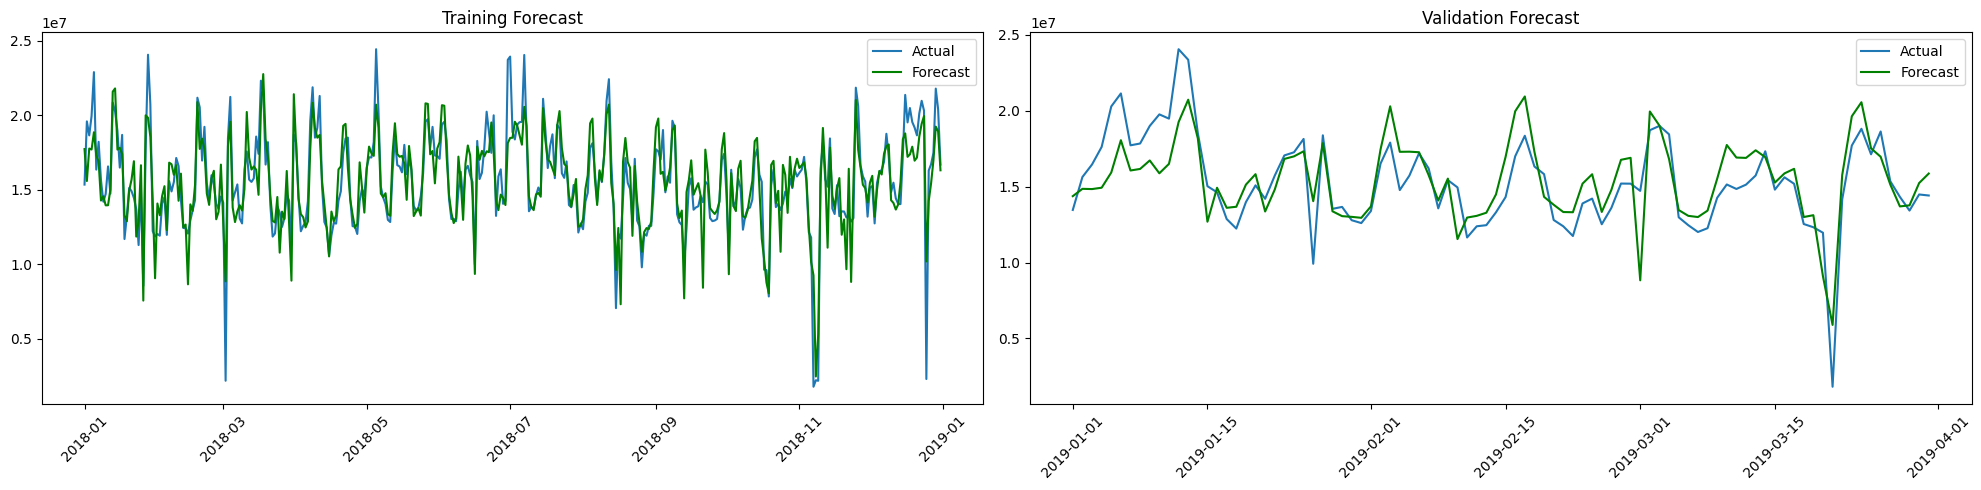

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error

# Define feature sets
feature_sets = [
    ['Store_id', 'day_of_week', 'Holiday', 'Discount'],
    ['Store_id', 'high_sales_quarter', 'day_of_week', 'Holiday', 'Discount'],
    ['Store_id', 'high_sales_month', 'day_of_week', 'Holiday', 'Discount'],
    ['Store_id', 'high_sales_day', 'day_of_week', 'Holiday', 'Discount']
]

best_set = None
best_train_mape = float('inf')
best_val_mape = float('inf')
best_forecasts = None

for feature_set in feature_sets:
    # Prepare exogenous data
    scaler = MinMaxScaler()
    exog_df = df_train.groupby(feature_set)['sales_per_day'].mean().round(2).rename('exg').reset_index()
    exog_df['exg_normalized'] = scaler.fit_transform(exog_df[['exg']])

    def exg(df, exog_df):
        df_exg = pd.merge(df, exog_df, on=feature_set, how='left')
        df_exg_final = df_exg.groupby(['Date']).agg({'sales_per_day': 'sum', 'exg_normalized': 'mean'}).reset_index()
        df_exg_final['exg_normalized'].fillna(0, inplace=True)
        return df_exg_final

    df_list = [df_train, df_val, df_test]
    df_train_exg, df_val_exg, df_test_exg = [exg(df_new, exog_df) for df_new in df_list]

    # Fit SARIMAX model
    p, d, q, P, D, Q, s = 1, 0, 3, 0, 0, 0, 0
    model_sarimax = SARIMAX(df_train_exg['sales_per_day'], order=(p, d, q), 
                              seasonal_order=(P, D, Q, s), 
                              exog=df_train_exg[['exg_normalized']], 
                              enforce_stationarity=False, 
                              enforce_invertibility=False).fit()

    # Forecast and calculate MAPE
    train_forecast = model_sarimax.predict(steps=df_train_exg.shape[0], exog=df_train_exg[['exg_normalized']])
    val_forecast = model_sarimax.forecast(steps=df_val_exg.shape[0], exog=df_val_exg[['exg_normalized']])

    train_mape = round(mean_absolute_percentage_error(df_train_exg['sales_per_day'], train_forecast) * 100, 2)
    val_mape = round(mean_absolute_percentage_error(df_val_exg['sales_per_day'], val_forecast) * 100, 2)

    print(f'Feature Set: {feature_set}')
    print(f'Training MAPE: {train_mape}% | Validation MAPE: {val_mape}%')
    print('-------------------------------------------------') 

    if val_mape < best_val_mape:
        best_set = feature_set
        best_train_mape = train_mape
        best_val_mape = val_mape
        best_forecasts = (df_train_exg, train_forecast, df_val_exg, val_forecast) 

# Plot for best feature set
print(f'Best Feature Set: {best_set}')
print(f'Best Training MAPE: {best_train_mape}% | Best Validation MAPE: {best_val_mape}%')

df_train_exg, train_forecast, df_val_exg, val_forecast = best_forecasts

plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.plot(df_train_exg['Date'], df_train_exg['sales_per_day'], label='Actual')
plt.plot(df_train_exg['Date'], train_forecast, label='Forecast', color='green')
plt.title('Training Forecast')
plt.xticks(rotation=45)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(df_val_exg['Date'], df_val_exg['sales_per_day'], label='Actual')
plt.plot(df_val_exg['Date'], val_forecast, label='Forecast', color='green')
plt.title('Validation Forecast')
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.show()


***Insights:*** Grouping by ***high_sales_quarter*** led to the best overall performance. This highlights the value of combining domain-specific patterns with SARIMAX for improved forecasting

**Residual Analysis**

After forecasting with the best SARIMAX model, I performed residual analysis:

* Scatter Plot: Plotted residuals vs. forecasted values for train and validation sets to check for bias or heteroscedasticity (none observed)
* Q-Q Plot: To check if Residuals approximately followed a normal distribution, validating model assumptions

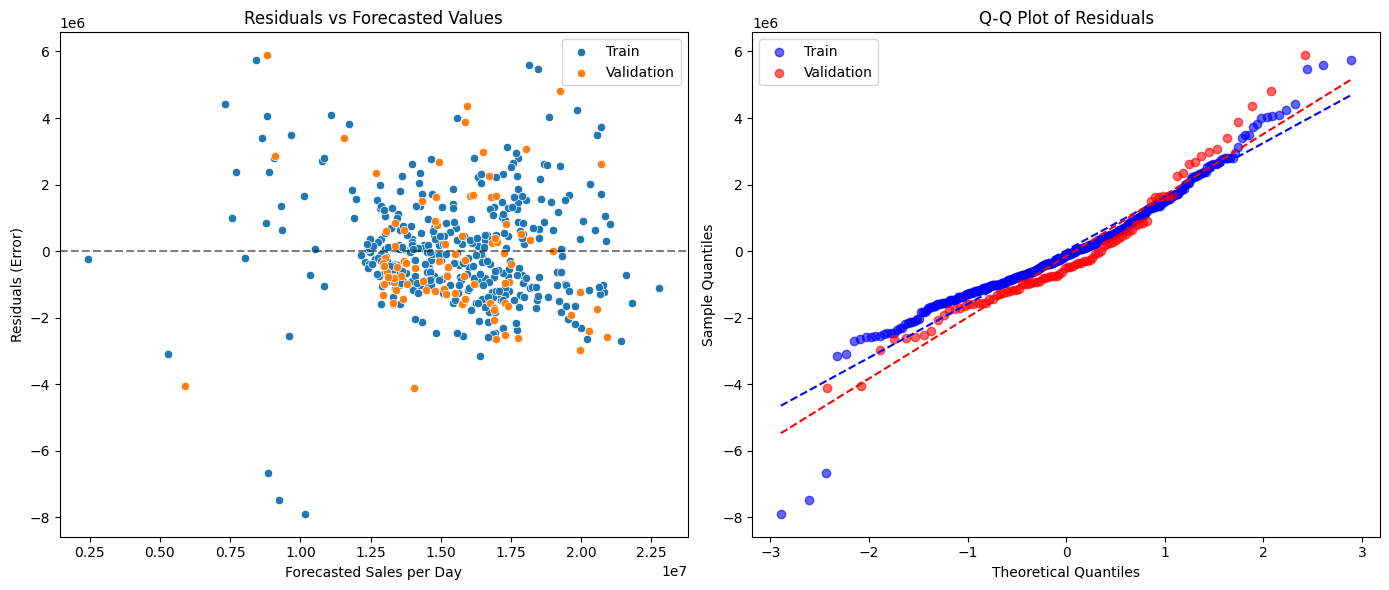

In [28]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

# Calculate residuals
err_train = df_train_exg['sales_per_day'] - train_forecast
err_val = np.array(df_val_exg['sales_per_day']) - np.array(val_forecast)

# Create figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# === Subplot 1: Scatter plot of residuals vs. forecast ===
sns.scatterplot(x=train_forecast, y=err_train, label='Train', ax=axes[0])
sns.scatterplot(x=val_forecast, y=err_val, label='Validation', ax=axes[0])
axes[0].axhline(0, linestyle='--', color='black', alpha=0.5)  # Reference line at 0
axes[0].set_xlabel("Forecasted Sales per Day")
axes[0].set_ylabel("Residuals (Error)")
axes[0].legend()
axes[0].set_title("Residuals vs Forecasted Values")

# === Subplot 2: Q-Q plot for both Train & Validation Residuals ===
# Compute Q-Q points
qq_train = stats.probplot(err_train, dist="norm")
qq_val = stats.probplot(err_val, dist="norm")

# Scatter plot of Q-Q points
axes[1].scatter(qq_train[0][0], qq_train[0][1], color='blue', alpha=0.6, label="Train")
axes[1].scatter(qq_val[0][0], qq_val[0][1], color='red', alpha=0.6, label="Validation")

# Best fit lines
slope_train, intercept_train, *_ = qq_train[1]
slope_val, intercept_val, *_ = qq_val[1]
x_vals = np.linspace(min(qq_train[0][0].min(), qq_val[0][0].min()), 
                     max(qq_train[0][0].max(), qq_val[0][0].max()), 100)
axes[1].plot(x_vals, slope_train * x_vals + intercept_train, color='blue', linestyle='--')
axes[1].plot(x_vals, slope_val * x_vals + intercept_val, color='red', linestyle='--')

axes[1].set_title("Q-Q Plot of Residuals")
axes[1].set_xlabel("Theoretical Quantiles")
axes[1].set_ylabel("Sample Quantiles")
axes[1].legend()

plt.tight_layout()
plt.show()

**Residuals vs Forecasted Values:**

1. Residuals are ***randomly scattered***, which is good
2. However, variance increases at higher forecast values, suggesting ***heteroscedasticity*** (inconsistent error variance)

**Q-Q Plot of Residuals:**

1. Residuals are approximately ***normal***, but heavy tails indicate some ***extreme errors (outliers)***
2. The lower tail (left side) deviates more, meaning the model ***underestimates*** sales in some cases

**Capping Outliers**

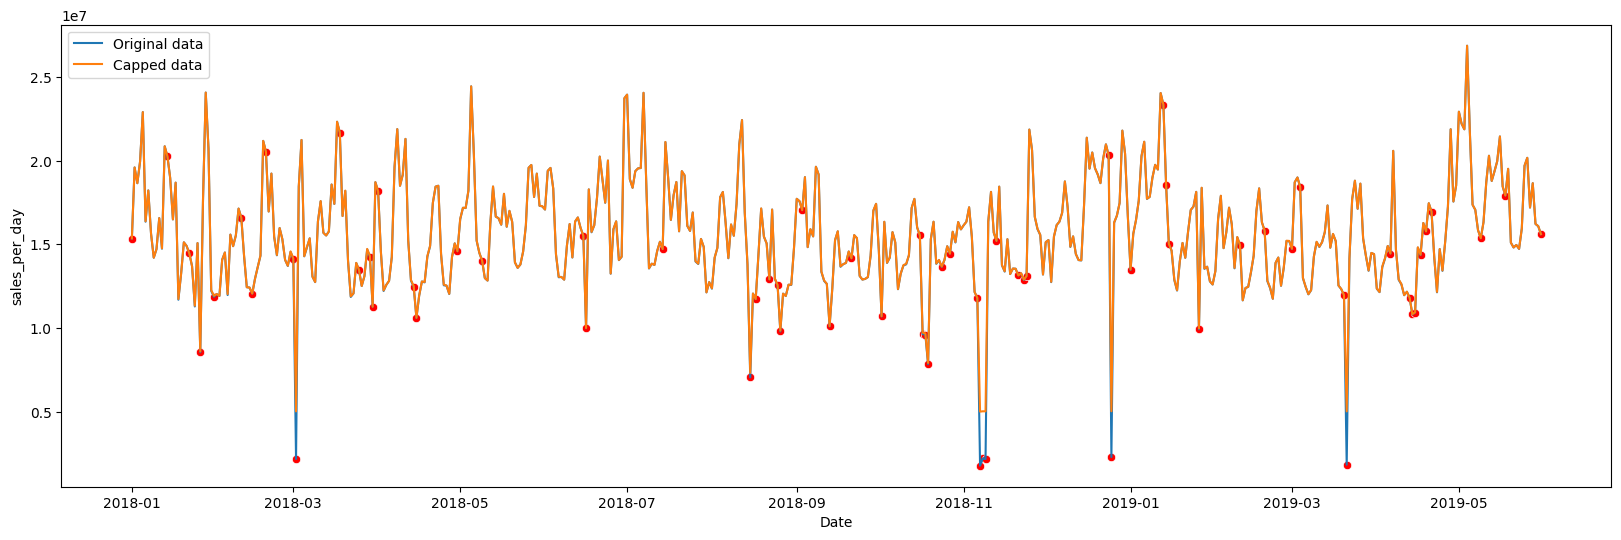

In [29]:
perc_2 = np.percentile(df['sales_per_day'], 2) # 2 percentile
#perc_98 = np.percentile(df['sales_per_day'], 98) # 98 percentile
    
df_outliers_removed = df.copy()  # Ensure modification without SettingWithCopyWarning 
df_outliers_removed['sales_per_day_capped'] = df_outliers_removed['sales_per_day']  # Create a new column first 
df_outliers_removed.loc[df_outliers_removed['sales_per_day_capped'] < perc_2, 'sales_per_day_capped'] = perc_2
#df_outliers_removed.loc[df_outliers_removed['sales_per_day_capped'] > perc_98, 'sales_per_day_capped'] = perc_98 

# original vs capped data
plt.figure(figsize = (20,6))
sns.lineplot(df.groupby(['Date'])['sales_per_day'].sum(), label = 'Original data')
sns.lineplot(df_outliers_removed.groupby(['Date'])['sales_per_day_capped'].sum(), label = 'Capped data')

df_outliers_removed_holiday = df_outliers_removed[df_outliers_removed['Holiday'] == 1]
df_holiday_sales =df_outliers_removed_holiday.groupby(['Date'])['sales_per_day'].sum().reset_index()
sns.scatterplot(x = df_holiday_sales['Date'], y = df_holiday_sales['sales_per_day'], color = 'red')

plt.show()

1. There are certain holidays when ***sales have dropped drastically***. Further analysis on these dates would provide exact reason for such big drops, which could be factored into the model later
2. Since I do not have relevant details about these dates, I have capped these sales to ***2% percentile*** to remove extreme sharp drops

In [30]:
# splitting the data 
df_train_capped = df_outliers_removed[df_outliers_removed['Date'] < '2019-1-1'].copy() # 12 months / 1 year 
df_val_capped = df_outliers_removed[(df_outliers_removed['Date'] >= '2019-1-1')&(df_outliers_removed['Date'] < '2019-4-1')].copy() # last 3 months before test data
df_test_capped = df_outliers_removed[df_outliers_removed['Date'] >= '2019-4-1'].copy() # last 2 months of the data 

# months with higher sales than global average
months = [1,5,6,7,12]  
df_train_capped['high_sales_month'] = np.where(df_train_capped['month'].isin(months), 1, 0)
df_val_capped['high_sales_month'] = np.where(df_val_capped['month'].isin(months), 1, 0)
df_test_capped['high_sales_month'] = np.where(df_test_capped['month'].isin(months), 1, 0) 

# days with higher sales than global average
days = [3,4,5]  
df_train_capped['high_sales_day'] = np.where(df_train_capped['day'].isin(days), 1, 0)
df_val_capped['high_sales_day'] = np.where(df_val_capped['day'].isin(days), 1, 0)
df_test_capped['high_sales_day'] = np.where(df_test_capped['day'].isin(days), 1, 0) 

# quarter with higher sales than global average
quarter = [2]  
df_train_capped['high_sales_quarter'] = np.where(df_train_capped['quarter'].isin(quarter), 1, 0)
df_val_capped['high_sales_quarter'] = np.where(df_val_capped['quarter'].isin(quarter), 1, 0)
df_test_capped['high_sales_quarter'] = np.where(df_test_capped['quarter'].isin(quarter), 1, 0) 

Feature Set: ['Store_id', 'day_of_week', 'Holiday', 'Discount']
Training MAPE: 10.31% | Validation MAPE: 10.13%
-------------------------------------------------
Feature Set: ['Store_id', 'high_sales_quarter', 'day_of_week', 'Holiday', 'Discount']
Training MAPE: 9.85% | Validation MAPE: 9.96%
-------------------------------------------------
Feature Set: ['Store_id', 'high_sales_month', 'day_of_week', 'Holiday', 'Discount']
Training MAPE: 9.04% | Validation MAPE: 11.09%
-------------------------------------------------
Feature Set: ['Store_id', 'high_sales_day', 'day_of_week', 'Holiday', 'Discount']
Training MAPE: 10.37% | Validation MAPE: 10.5%
-------------------------------------------------
Best Feature Set: ['Store_id', 'high_sales_quarter', 'day_of_week', 'Holiday', 'Discount']
Best Training MAPE: 9.85% | Best Validation MAPE: 9.96%


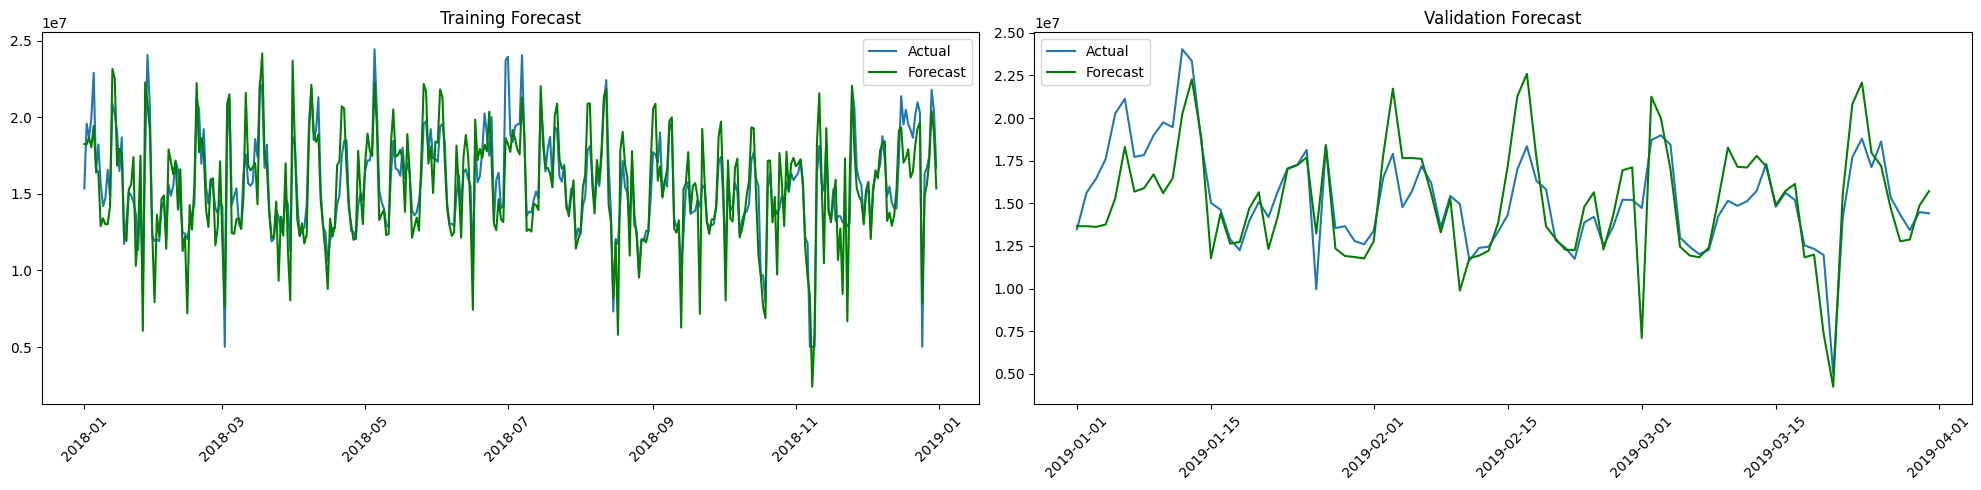

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error

# Define feature sets
feature_sets = [
    ['Store_id', 'day_of_week', 'Holiday', 'Discount'],
    ['Store_id', 'high_sales_quarter', 'day_of_week', 'Holiday', 'Discount'],
    ['Store_id', 'high_sales_month', 'day_of_week', 'Holiday', 'Discount'],
    ['Store_id', 'high_sales_day', 'day_of_week', 'Holiday', 'Discount']
]

best_set = None
best_train_mape = float('inf')
best_val_mape = float('inf')
best_forecasts = None 

for feature_set in feature_sets:
    # Prepare exogenous data
    scaler = MinMaxScaler()
    exog_df = df_train_capped.groupby(feature_set)['sales_per_day_capped'].mean().round(2).rename('exg').reset_index()
    exog_df['exg_normalized'] = scaler.fit_transform(exog_df[['exg']])

    def exg(df, exog_df):
        df_exg = pd.merge(df, exog_df, on=feature_set, how='left')
        df_exg_final = df_exg.groupby(['Date']).agg({'sales_per_day_capped': 'sum', 'exg_normalized': 'mean'}).reset_index()
        df_exg_final['exg_normalized'].fillna(0, inplace=True)
        return df_exg_final

    df_list = [df_train_capped, df_val_capped, df_test_capped] 
    df_train_exg, df_val_exg, df_test_exg = [exg(df_new, exog_df) for df_new in df_list]

    # Fit SARIMAX model
    p, d, q, P, D, Q, s = 1, 0, 3, 0, 0, 0, 0
    model_sarimax = SARIMAX(df_train_exg['sales_per_day_capped'], order=(p, d, q), 
                              seasonal_order=(P, D, Q, s), 
                              exog=df_train_exg[['exg_normalized']], 
                              enforce_stationarity=False, 
                              enforce_invertibility=False).fit() 

    # Forecast and calculate MAPE
    train_forecast = model_sarimax.predict(steps=df_train_exg.shape[0], exog=df_train_exg[['exg_normalized']])
    val_forecast = model_sarimax.forecast(steps=df_val_exg.shape[0], exog=df_val_exg[['exg_normalized']])

    train_mape = round(mean_absolute_percentage_error(df_train_exg['sales_per_day_capped'], train_forecast) * 100, 2)
    val_mape = round(mean_absolute_percentage_error(df_val_exg['sales_per_day_capped'], val_forecast) * 100, 2)

    print(f'Feature Set: {feature_set}')
    print(f'Training MAPE: {train_mape}% | Validation MAPE: {val_mape}%')
    print('-------------------------------------------------') 

    if val_mape < best_val_mape:
        best_set = feature_set
        best_train_mape = train_mape
        best_val_mape = val_mape
        best_forecasts = (df_train_exg, train_forecast, df_val_exg, val_forecast) 

# Plot for best feature set
print(f'Best Feature Set: {best_set}')
print(f'Best Training MAPE: {best_train_mape}% | Best Validation MAPE: {best_val_mape}%')

df_train_exg, train_forecast, df_val_exg, val_forecast = best_forecasts

plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.plot(df_train_exg['Date'], df_train_exg['sales_per_day_capped'], label='Actual')
plt.plot(df_train_exg['Date'], train_forecast, label='Forecast', color='green')
plt.title('Training Forecast')
plt.xticks(rotation=45)
plt.legend()

plt.subplot(1, 2, 2) 
plt.plot(df_val_exg['Date'], df_val_exg['sales_per_day_capped'], label='Actual')
plt.plot(df_val_exg['Date'], val_forecast, label='Forecast', color='green')
plt.title('Validation Forecast')
plt.xticks(rotation=45)
plt.legend() 

plt.tight_layout()
plt.show()

* Validation MAPE for ['Store_id', 'high_sales_quarter', 'day_of_week', 'Holiday', 'Discount'] ---> reduced by 2% points after outliers are capped at 2% percetile from ***11.52% to 9.96%***

### Rolling Monthly Forecasting

In [32]:
start_date = '2018-1-1'
time = ['2019-1-1','2019-2-1','2019-3-1','2019-4-1','2019-5-1','2019-6-1']
feature_sets = [['Store_id', 'high_sales_quarter', 'day_of_week', 'Holiday', 'Discount']]

for features in feature_sets:
    print(f'Feature set: {features}')
    print('xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx') 
    for i,t in enumerate(time):
        t_plus_1 = time[i+1]
        df_train = df_outliers_removed[df_outliers_removed['Date'] < t].copy() 
        df_val = df_outliers_removed[(df_outliers_removed['Date'] >= t)&(df_outliers_removed['Date'] < t_plus_1)].copy() 
    
        # months with higher sales than global average
        quarter = [2]  
        df_train['high_sales_quarter'] = np.where(df_train['quarter'].isin(quarter), 1, 0)
        df_val['high_sales_quarter'] = np.where(df_val['quarter'].isin(quarter), 1, 0) 
    
        scaler = MinMaxScaler()
        exog_df = df_train.groupby(features)['sales_per_day_capped'].mean().round(2).rename('exg').reset_index()
        exog_df['exg_normalized'] = scaler.fit_transform(exog_df[['exg']])

        def exg(df, exog_df):
            df_exg = pd.merge(df, exog_df, on=features, how='left')
            df_exg_final = df_exg.groupby(['Date','Holiday']).agg({'sales_per_day_capped': 'sum', 'exg_normalized': 'mean'}).reset_index()
            df_exg_final['exg_normalized'].fillna(0, inplace=True) 
            return df_exg_final

        df_list = [df_train, df_val]
        df_train_exg, df_val_exg = [exg(df_new, exog_df) for df_new in df_list] 
    
         # Fit SARIMAX model
        p, d, q, P, D, Q, s = 1, 0, 3, 0, 0, 0, 0
        model_sarimax = SARIMAX(df_train_exg['sales_per_day_capped'], order=(p, d, q), 
                                  seasonal_order=(P, D, Q, s), 
                                  exog=df_train_exg[['exg_normalized']], 
                                  enforce_stationarity=False, 
                                  enforce_invertibility=False).fit() 
    
        # Forecast and calculate MAPE
        train_forecast = model_sarimax.predict(steps=df_train_exg.shape[0], exog=df_train_exg[['exg_normalized']])
        val_forecast = model_sarimax.forecast(steps=df_val_exg.shape[0], exog=df_val_exg[['exg_normalized']]) 
    
        train_mape = round(mean_absolute_percentage_error(df_train_exg['sales_per_day_capped'], train_forecast) * 100, 2)
        val_mape = round(mean_absolute_percentage_error(df_val_exg['sales_per_day_capped'], val_forecast) * 100, 2)
    
        print(f'Train: {start_date} - {t}, Validation: {t} - {t_plus_1}') 
        print(f'Training MAPE: {train_mape}% | Validation MAPE: {val_mape}%')
        print('-------------------------------------------------------------------') 
    
        if len(time) == i+2:
            break

Feature set: ['Store_id', 'high_sales_quarter', 'day_of_week', 'Holiday', 'Discount']
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
Train: 2018-1-1 - 2019-1-1, Validation: 2019-1-1 - 2019-2-1
Training MAPE: 9.85% | Validation MAPE: 10.18%
-------------------------------------------------------------------
Train: 2018-1-1 - 2019-2-1, Validation: 2019-2-1 - 2019-3-1
Training MAPE: 9.88% | Validation MAPE: 9.81%
-------------------------------------------------------------------
Train: 2018-1-1 - 2019-3-1, Validation: 2019-3-1 - 2019-4-1
Training MAPE: 9.66% | Validation MAPE: 10.48%
-------------------------------------------------------------------
Train: 2018-1-1 - 2019-4-1, Validation: 2019-4-1 - 2019-5-1
Training MAPE: 9.57% | Validation MAPE: 14.14%
-------------------------------------------------------------------
Train: 2018-1-1 - 2019-5-1, Validation: 2019-5-1 - 2019-6-1
Training MAPE: 9.59% | Validation MAPE: 17.14%
----------------------------

In [33]:
start_date = '2018-1-1'
time = ['2019-1-1','2019-2-1','2019-3-1','2019-4-1','2019-5-1','2019-6-1']
feature_sets = [['Store_id', 'high_sales_quarter', 'day_of_week', 'Holiday', 'Discount']]

mape = []

for features in feature_sets:
    print(f'Feature set: {features}')
    print('xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx') 
    for i,t in enumerate(time):
        t_plus_1 = time[i+1]
        df_train = df_outliers_removed[df_outliers_removed['Date'] < t].copy() 
        df_val = df_outliers_removed[(df_outliers_removed['Date'] >= t)&(df_outliers_removed['Date'] < t_plus_1)].copy() 
    
        # months with higher sales than global average
        quarter = [2]  
        df_train['high_sales_quarter'] = np.where(df_train['quarter'].isin(quarter), 1, 0)
        df_val['high_sales_quarter'] = np.where(df_val['quarter'].isin(quarter), 1, 0) 
    
        scaler = MinMaxScaler()
        exog_df = df_train.groupby(features)['sales_per_day_capped'].median().round(2).rename('exg').reset_index()
        exog_df['exg_normalized'] = scaler.fit_transform(exog_df[['exg']])

        def exg(df, exog_df):
            df_exg = pd.merge(df, exog_df, on=features, how='left')
            df_exg_final = df_exg.groupby(['Date','Holiday']).agg({'sales_per_day_capped': 'sum', 'exg_normalized': 'mean'}).reset_index()
            df_exg_final['exg_normalized'].fillna(0, inplace=True) 
            return df_exg_final

        df_list = [df_train, df_val]
        df_train_exg, df_val_exg = [exg(df_new, exog_df) for df_new in df_list] 
    
         # Fit SARIMAX model
        p, d, q, P, D, Q, s = 1, 0, 3, 0, 0, 0, 0
        model_sarimax = SARIMAX(df_train_exg['sales_per_day_capped'], order=(p, d, q), 
                                  seasonal_order=(P, D, Q, s), 
                                  exog=df_train_exg[['exg_normalized']], 
                                  enforce_stationarity=False, 
                                  enforce_invertibility=False).fit() 
    
        # Forecast and calculate MAPE
        train_forecast = model_sarimax.predict(steps=df_train_exg.shape[0], exog=df_train_exg[['exg_normalized']])
        val_forecast = model_sarimax.forecast(steps=df_val_exg.shape[0], exog=df_val_exg[['exg_normalized']]) 
    
        train_mape = round(mean_absolute_percentage_error(df_train_exg['sales_per_day_capped'], train_forecast) * 100, 2)
        val_mape = round(mean_absolute_percentage_error(df_val_exg['sales_per_day_capped'], val_forecast) * 100, 2)
        mape.append(val_mape)
    
        print(f'Train: {start_date} - {t}, Validation: {t} - {t_plus_1}') 
        print(f'Training MAPE: {train_mape}% | Validation MAPE: {val_mape}%')
        print('-------------------------------------------------------------------') 
    
        if len(time) == i+2:
            break

mape_avg = np.mean(mape).round(2)
print(f'Rolling average validation MAPE ---> {mape_avg}%') 

Feature set: ['Store_id', 'high_sales_quarter', 'day_of_week', 'Holiday', 'Discount']
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
Train: 2018-1-1 - 2019-1-1, Validation: 2019-1-1 - 2019-2-1
Training MAPE: 9.25% | Validation MAPE: 10.2%
-------------------------------------------------------------------
Train: 2018-1-1 - 2019-2-1, Validation: 2019-2-1 - 2019-3-1
Training MAPE: 9.4% | Validation MAPE: 9.6%
-------------------------------------------------------------------
Train: 2018-1-1 - 2019-3-1, Validation: 2019-3-1 - 2019-4-1
Training MAPE: 9.13% | Validation MAPE: 8.84%
-------------------------------------------------------------------
Train: 2018-1-1 - 2019-4-1, Validation: 2019-4-1 - 2019-5-1
Training MAPE: 9.15% | Validation MAPE: 13.53%
-------------------------------------------------------------------
Train: 2018-1-1 - 2019-5-1, Validation: 2019-5-1 - 2019-6-1
Training MAPE: 9.17% | Validation MAPE: 17.3%
---------------------------------

**Impact of Holidays**

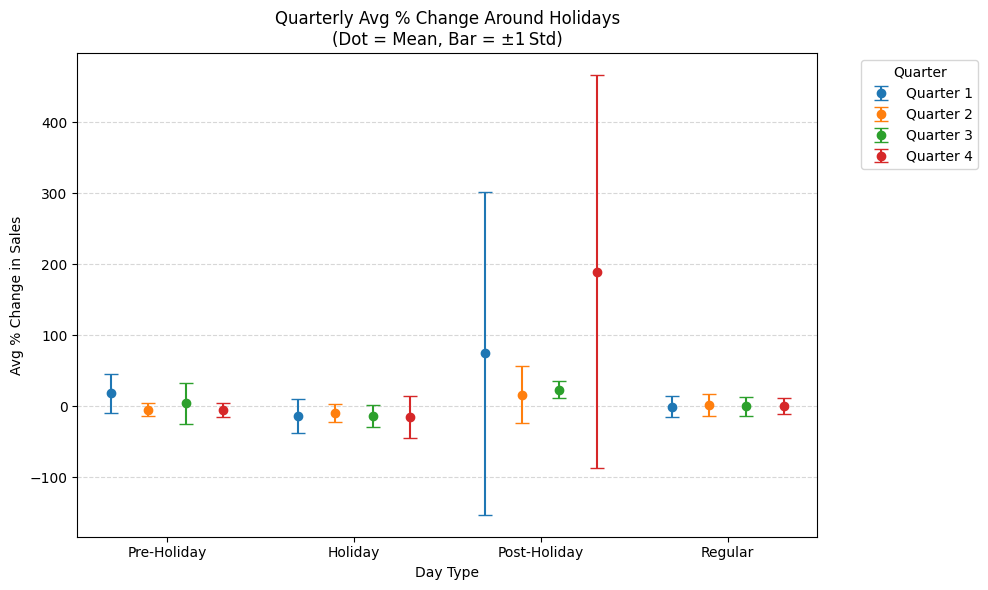

,quarter,day_type,mean,median,std,count
0,1,Holiday,-13.75,-2.96,24.35,13
1,1,Post-Holiday,74.75,-5.28,227.45,11
2,1,Pre-Holiday,18.21,13.65,27.88,12
3,1,Regular,-0.45,1.55,15.30,53
4,2,Holiday,-9.38,-3.13,12.43,7


In [34]:
df_holiday = df.groupby(['Date','quarter','Holiday'])['sales_per_day'].sum().reset_index()

df_holiday = df_holiday.loc[:364,:] # only training data is considered
df_holiday['is_holiday'] = df_holiday['Holiday'] == 1
df_holiday['pre_holiday']  = df_holiday['is_holiday'].shift(-1).fillna(False)  # the next day is holiday
df_holiday['post_holiday'] = df_holiday['is_holiday'].shift(1).fillna(False)

# assign labels
def label_day(row):
    if row['is_holiday']:
        return 'Holiday'
    if row['pre_holiday']:
        return 'Pre-Holiday'
    if row['post_holiday']:
        return 'Post-Holiday'
    return 'Regular'
    
df_holiday['day_type'] = df_holiday.apply(label_day, axis=1)

df_holiday['sales_change_pct'] = np.round(df_holiday['sales_per_day'].pct_change() * 100,2)
df_holiday_stat = df_holiday.groupby(['quarter','day_type'])['sales_change_pct'].agg(['mean','median','std','count']).round(2).reset_index()


# Ensure day_type order
day_order = ['Pre-Holiday', 'Holiday', 'Post-Holiday', 'Regular']
df_holiday_stat['day_type'] = pd.Categorical(df_holiday_stat['day_type'],
                                             categories=day_order,
                                             ordered=True)

# Sort by quarter and day_type
df_plot = df_holiday_stat.sort_values(['quarter','day_type'])

fig, ax = plt.subplots(figsize=(10, 6))

# Unique quarters (e.g. Q1, Q2, …)
quarters = df_plot['quarter'].unique()
colors = plt.cm.tab10.colors  # cycle of colors

for i, q in enumerate(quarters):
    sub = df_plot[df_plot['quarter'] == q]
    # x positions: offset each quarter slightly
    x = range(len(day_order))
    x_offset = [xi + (i - (len(quarters)-1)/2)*0.2 for xi in x]
    
    ax.errorbar(
        x_offset,
        sub['mean'],
        yerr=sub['std'],
        fmt='o',
        capsize=5,
        label=f'Quarter {q}',
        color=colors[i % len(colors)]
    )

# X-axis
ax.set_xticks(range(len(day_order)))
ax.set_xticklabels(day_order)
ax.set_xlabel('Day Type')
ax.set_ylabel('Avg % Change in Sales')
ax.set_title('Quarterly Avg % Change Around Holidays\n(Dot = Mean, Bar = ±1 Std)')
ax.legend(title='Quarter', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

#from sklearn.preprocessing import StandardScaler, MinMaxScaler
#scaler = StandardScaler() 

#cols_to_scale = ['mean', 'median', 'std']
#df_holiday_stat[cols_to_scale] = scaler.fit_transform(df_holiday_stat[cols_to_scale])

#scaler_2 = MinMaxScaler()
#df_holiday_stat['count'] = scaler_2.fit_transform(df_holiday_stat[['count']])

df_holiday_stat.head()

In [35]:
start_date = '2018-1-1'
time = ['2019-1-1','2019-2-1','2019-3-1','2019-4-1','2019-5-1','2019-6-1']
feature_sets = [['Store_id', 'high_sales_quarter', 'day_of_week', 'Holiday', 'Discount']]

mape = []

for features in feature_sets:
    print(f'Feature set: {features}')
    print('xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx') 
    for i,t in enumerate(time):
        t_plus_1 = time[i+1]
        df_train = df_outliers_removed[df_outliers_removed['Date'] < t].copy() 
        df_val = df_outliers_removed[(df_outliers_removed['Date'] >= t)&(df_outliers_removed['Date'] < t_plus_1)].copy() 
    
        # months with higher sales than global average
        quarter = [2]  
        df_train['high_sales_quarter'] = np.where(df_train['quarter'].isin(quarter), 1, 0)
        df_val['high_sales_quarter'] = np.where(df_val['quarter'].isin(quarter), 1, 0) 
    
        scaler = MinMaxScaler()
        exog_df = df_train.groupby(features)['sales_per_day_capped'].median().round(2).rename('exg').reset_index()
        exog_df['exg_normalized'] = scaler.fit_transform(exog_df[['exg']])

        def exg(df, exog_df):
            df_exg = pd.merge(df, exog_df, on=features, how='left')
            df_exg_final = df_exg.groupby(['Date','Holiday']).agg({'sales_per_day_capped': 'sum', 'exg_normalized': 'mean'}).reset_index()
            df_exg_final['exg_normalized'].fillna(0, inplace=True) 
            return df_exg_final

        df_list = [df_train, df_val]
        df_train_exg, df_val_exg = [exg(df_new, exog_df) for df_new in df_list] 

        def holiday_effect(df):
            df['quarter'] = df['Date'].dt.quarter
            df['is_holiday'] = df['Holiday'] == 1
            df['pre_holiday']  = df['is_holiday'].shift(-1).fillna(False)  # the next day is holiday
            df['post_holiday'] = df['is_holiday'].shift(1).fillna(False)
        
        # assign labels
            def label_day(row):
                if row['is_holiday']:
                    return 'Holiday'
                if row['pre_holiday']:
                    return 'Pre-Holiday'
                if row['post_holiday']:
                    return 'Post-Holiday'
                return 'Regular'
            
            df['day_type'] = df.apply(label_day, axis=1)
            return df

        df_list_2 = [df_train_exg, df_val_exg]
        df_train_exg_holiday, df_val_exg_holiday = [holiday_effect(df_new) for df_new in df_list_2]  

        df_train_exg_holiday_final = pd.merge(df_train_exg_holiday, df_holiday_stat, on = ['quarter','day_type'], how = 'left') 
        df_val_exg_holiday_final = pd.merge(df_val_exg_holiday, df_holiday_stat, on = ['quarter','day_type'], how = 'left')
    
         # Fit SARIMAX model
        p, d, q, P, D, Q, s = 1, 0, 3, 0, 0, 0, 0
        model_sarimax = SARIMAX(df_train_exg_holiday_final['sales_per_day_capped'], order=(p, d, q), 
                                  seasonal_order=(P, D, Q, s), 
                                  exog=df_train_exg_holiday_final[['exg_normalized','mean']], 
                                  enforce_stationarity=False, 
                                  enforce_invertibility=False).fit() 
    
        # Forecast and calculate MAPE
        train_forecast = model_sarimax.predict(steps=df_train_exg_holiday_final.shape[0], exog=df_train_exg_holiday_final[['exg_normalized',
                                                                                                                           'mean'
                                                                                                                          ]])
        val_forecast = model_sarimax.forecast(steps=df_val_exg_holiday_final.shape[0], exog=df_val_exg_holiday_final[['exg_normalized',
                                                                                                                      'mean'
                                                                                                                     ]]) 
    
        train_mape = round(mean_absolute_percentage_error(df_train_exg_holiday_final['sales_per_day_capped'], train_forecast) * 100, 2)
        val_mape = round(mean_absolute_percentage_error(df_val_exg_holiday_final['sales_per_day_capped'], val_forecast) * 100, 2)
        mape.append(val_mape)
    
        print(f'Train: {start_date} - {t}, Validation: {t} - {t_plus_1}') 
        print(f'Training MAPE: {train_mape}% | Validation MAPE: {val_mape}%')
        print('-------------------------------------------------------------------') 
    
        if len(time) == i+2:
            break

mape_avg = np.mean(mape).round(2)
print(f'Rolling average validation MAPE ---> {mape_avg}%') 

Feature set: ['Store_id', 'high_sales_quarter', 'day_of_week', 'Holiday', 'Discount']
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
Train: 2018-1-1 - 2019-1-1, Validation: 2019-1-1 - 2019-2-1
Training MAPE: 9.16% | Validation MAPE: 10.26%
-------------------------------------------------------------------
Train: 2018-1-1 - 2019-2-1, Validation: 2019-2-1 - 2019-3-1
Training MAPE: 9.3% | Validation MAPE: 9.8%
-------------------------------------------------------------------
Train: 2018-1-1 - 2019-3-1, Validation: 2019-3-1 - 2019-4-1
Training MAPE: 9.07% | Validation MAPE: 8.87%
-------------------------------------------------------------------
Train: 2018-1-1 - 2019-4-1, Validation: 2019-4-1 - 2019-5-1
Training MAPE: 9.08% | Validation MAPE: 13.64%
-------------------------------------------------------------------
Train: 2018-1-1 - 2019-5-1, Validation: 2019-5-1 - 2019-6-1
Training MAPE: 9.06% | Validation MAPE: 17.18%
-------------------------------

**Store Discount %**

In [36]:
all_dates = pd.DataFrame(df['Date'].unique(), columns=['Date']) # extracting all the dates

df_disc_perc = df.groupby(['Date','Discount'])['Store_id'].count().reset_index()
df_disc_perc = df_disc_perc[df_disc_perc['Discount'] == 1]
df_disc_perc['disc_perc'] = np.round(df_disc_perc['Store_id']/df['Store_id'].nunique(),3)

df_perc = pd.merge(all_dates, df_disc_perc, on = 'Date', how = 'left')
df_perc = df_perc.drop(columns = ['Discount','Store_id'])
df_perc = df_perc.fillna(0)

df_perc.head()

,Date,disc_perc
0,2018-01-01,1.000
1,2018-01-02,1.000
2,2018-01-03,1.000
3,2018-01-04,0.997
4,2018-01-05,0.997


In [37]:
start_date = '2018-1-1'
time = ['2019-1-1','2019-2-1','2019-3-1','2019-4-1','2019-5-1', '2019-6-1']
feature_sets = [['Store_id', 'high_sales_quarter', 'day_of_week', 'Holiday', 'Discount']]

mape = []

for features in feature_sets:
    print(f'Feature set: {features}')
    print('xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx') 
    for i,t in enumerate(time):
        t_plus_1 = time[i+1]
        df_train = df_outliers_removed[df_outliers_removed['Date'] < t].copy() 
        df_val = df_outliers_removed[(df_outliers_removed['Date'] >= t)&(df_outliers_removed['Date'] < t_plus_1)].copy() 
    
        # months with higher sales than global average
        quarter = [2]  
        df_train['high_sales_quarter'] = np.where(df_train['quarter'].isin(quarter), 1, 0)
        df_val['high_sales_quarter'] = np.where(df_val['quarter'].isin(quarter), 1, 0) 
    
        scaler = MinMaxScaler()
        exog_df = df_train.groupby(features)['sales_per_day_capped'].median().round(2).rename('exg').reset_index()
        exog_df['exg_normalized'] = scaler.fit_transform(exog_df[['exg']])

        def exg(df, exog_df):
            df_exg = pd.merge(df, exog_df, on=features, how='left')
            df_exg_final = df_exg.groupby(['Date','Holiday']).agg({'sales_per_day_capped': 'sum', 'exg_normalized': 'mean'}).reset_index()
            df_exg_final['exg_normalized'].fillna(0, inplace=True) 
            return df_exg_final

        df_list = [df_train, df_val]
        df_train_exg, df_val_exg = [exg(df_new, exog_df) for df_new in df_list] 

        def holiday_effect(df):
            df['quarter'] = df['Date'].dt.quarter
            df['is_holiday'] = df['Holiday'] == 1
            df['pre_holiday']  = df['is_holiday'].shift(-1).fillna(False)  # the next day is holiday
            df['post_holiday'] = df['is_holiday'].shift(1).fillna(False)
        
        # assign labels
            def label_day(row):
                if row['is_holiday']:
                    return 'Holiday'
                if row['pre_holiday']:
                    return 'Pre-Holiday'
                if row['post_holiday']:
                    return 'Post-Holiday'
                return 'Regular'
            
            df['day_type'] = df.apply(label_day, axis=1)
            return df

        df_list_2 = [df_train_exg, df_val_exg]
        df_train_exg_holiday, df_val_exg_holiday = [holiday_effect(df_new) for df_new in df_list_2]  

        df_train_exg_holiday_final = pd.merge(df_train_exg_holiday, df_holiday_stat, on = ['quarter','day_type'], how = 'left')
        df_train_exg_holiday_final_perc = pd.merge(df_train_exg_holiday_final, df_perc, on = 'Date', how = 'left') 
        
        df_val_exg_holiday_final = pd.merge(df_val_exg_holiday, df_holiday_stat, on = ['quarter','day_type'], how = 'left')
        df_val_exg_holiday_final_perc = pd.merge(df_val_exg_holiday_final, df_perc, on = 'Date', how = 'left')  
    
         # Fit SARIMAX model
        p, d, q, P, D, Q, s = 1, 0, 3, 0, 0, 0, 0
        model_sarimax = SARIMAX(df_train_exg_holiday_final_perc['sales_per_day_capped'], order=(p, d, q), 
                                  seasonal_order=(P, D, Q, s), 
                                  exog=df_train_exg_holiday_final_perc[['exg_normalized','disc_perc']], 
                                  enforce_stationarity=False, 
                                  enforce_invertibility=False).fit() 
    
        # Forecast and calculate MAPE
        train_forecast = model_sarimax.predict(steps=df_train_exg_holiday_final_perc.shape[0], exog=df_train_exg_holiday_final_perc[['exg_normalized',
                                                                                                                                     'disc_perc'
                                                                                                                           ]])
        val_forecast = model_sarimax.forecast(steps=df_val_exg_holiday_final_perc.shape[0], exog=df_val_exg_holiday_final_perc[['exg_normalized',
                                                                                                                                'disc_perc'
                                                                                                                      ]]) 
    
        train_mape = round(mean_absolute_percentage_error(df_train_exg_holiday_final_perc['sales_per_day_capped'], train_forecast) * 100, 2)
        val_mape = round(mean_absolute_percentage_error(df_val_exg_holiday_final_perc['sales_per_day_capped'], val_forecast) * 100, 2)
        mape.append(val_mape)
    
        print(f'Train: {start_date} - {t}, Validation: {t} - {t_plus_1}') 
        print(f'Training MAPE: {train_mape}% | Validation MAPE: {val_mape}%')
        print('-------------------------------------------------------------------') 
    
        if len(time) == i+2:
            break

mape_avg = np.mean(mape).round(2)
print(f'Rolling average validation MAPE ---> {mape_avg}%') 

Feature set: ['Store_id', 'high_sales_quarter', 'day_of_week', 'Holiday', 'Discount']
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
Train: 2018-1-1 - 2019-1-1, Validation: 2019-1-1 - 2019-2-1
Training MAPE: 9.19% | Validation MAPE: 9.78%
-------------------------------------------------------------------
Train: 2018-1-1 - 2019-2-1, Validation: 2019-2-1 - 2019-3-1
Training MAPE: 9.29% | Validation MAPE: 10.08%
-------------------------------------------------------------------
Train: 2018-1-1 - 2019-3-1, Validation: 2019-3-1 - 2019-4-1
Training MAPE: 9.04% | Validation MAPE: 8.87%
-------------------------------------------------------------------
Train: 2018-1-1 - 2019-4-1, Validation: 2019-4-1 - 2019-5-1
Training MAPE: 9.06% | Validation MAPE: 13.46%
-------------------------------------------------------------------
Train: 2018-1-1 - 2019-5-1, Validation: 2019-5-1 - 2019-6-1
Training MAPE: 9.08% | Validation MAPE: 16.08%
-----------------------------

**Capturing Interactions**

In [38]:
start_date = '2018-1-1'
time = ['2019-1-1','2019-2-1','2019-3-1','2019-4-1','2019-5-1','2019-6-1']
feature_sets = [['Store_id', 'high_sales_quarter', 'day_of_week', 'Holiday', 'Discount']]

mape = []

for features in feature_sets:
    print(f'Feature set: {features}')
    print('xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx') 
    for i,t in enumerate(time):
        t_plus_1 = time[i+1]
        df_train = df_outliers_removed[df_outliers_removed['Date'] < t].copy() 
        df_val = df_outliers_removed[(df_outliers_removed['Date'] >= t)&(df_outliers_removed['Date'] < t_plus_1)].copy() 
    
        # months with higher sales than global average
        quarter = [2]  
        df_train['high_sales_quarter'] = np.where(df_train['quarter'].isin(quarter), 1, 0)
        df_val['high_sales_quarter'] = np.where(df_val['quarter'].isin(quarter), 1, 0) 
    
        scaler = MinMaxScaler()
        exog_df = df_train.groupby(features)['sales_per_day_capped'].median().round(2).rename('exg').reset_index()
        exog_df['exg_normalized'] = scaler.fit_transform(exog_df[['exg']])

        def exg(df, exog_df):
            df_exg = pd.merge(df, exog_df, on=features, how='left')
            df_exg_final = df_exg.groupby(['Date','Holiday']).agg({'sales_per_day_capped': 'sum', 'exg_normalized': 'mean'}).reset_index()
            df_exg_final['exg_normalized'].fillna(0, inplace=True) 
            return df_exg_final

        df_list = [df_train, df_val]
        df_train_exg, df_val_exg = [exg(df_new, exog_df) for df_new in df_list]  

        def holiday_effect(df):
            df['quarter'] = df['Date'].dt.quarter
            df['is_holiday'] = df['Holiday'] == 1
            df['pre_holiday']  = df['is_holiday'].shift(-1).fillna(False)  # the next day is holiday
            df['post_holiday'] = df['is_holiday'].shift(1).fillna(False)
        
        # assign labels
            def label_day(row):
                if row['is_holiday']:
                    return 'Holiday'
                if row['pre_holiday']:
                    return 'Pre-Holiday'
                if row['post_holiday']:
                    return 'Post-Holiday'
                return 'Regular'
            
            df['day_type'] = df.apply(label_day, axis=1)
            df = df.drop(columns=['is_holiday','pre_holiday','post_holiday'])
            return df

        df_list_2 = [df_train_exg, df_val_exg]
        df_train_exg_holiday, df_val_exg_holiday = [holiday_effect(df_new) for df_new in df_list_2]  

        df_train_exg_holiday_final = pd.merge(df_train_exg_holiday, df_holiday_stat, on = ['quarter','day_type'], how = 'left')
        df_train_exg_holiday_final_perc = pd.merge(df_train_exg_holiday_final, df_perc, on = 'Date', how = 'left')

        
        df_val_exg_holiday_final = pd.merge(df_val_exg_holiday, df_holiday_stat, on = ['quarter','day_type'], how = 'left')
        df_val_exg_holiday_final_perc = pd.merge(df_val_exg_holiday_final, df_perc, on = 'Date', how = 'left') 

        def feats(df):
            df['perc_mean'] = df['mean'] * df['disc_perc']
            df['exg_mean_perc'] = df['exg_normalized']*df['mean']*df['disc_perc']
            df['exg_median_perc'] = df['exg_normalized']*df['median']*df['disc_perc']
            df['var_range'] = (df['mean']+df['std']) - (df['mean']-df['std'])
            df['var_range_median'] = (df['median']+df['std']) - (df['median']-df['std'])
            return df

        df_list_3 = [df_train_exg_holiday_final_perc, df_val_exg_holiday_final_perc]
        train, val = [feats(df_new) for df_new in df_list_3]
        
        exog = ['exg_normalized','disc_perc','mean', 'perc_mean','exg_mean_perc', 'exg_median_perc', 'var_range', 'var_range_median'] 
    
         # Fit SARIMAX model
        p, d, q, P, D, Q, s = 1, 0, 3, 0, 0, 0, 0
        model_sarimax = SARIMAX(train['sales_per_day_capped'], order=(p, d, q), 
                                  seasonal_order=(P, D, Q, s), 
                                  exog=train[exog], 
                                  enforce_stationarity=False, 
                                  enforce_invertibility=False).fit() 
    
        # Forecast and calculate MAPE
        train_forecast = model_sarimax.predict(steps=train.shape[0], exog=train[exog])
        val_forecast = model_sarimax.forecast(steps=val.shape[0], exog=val[exog]) 
    
        train_mape = round(mean_absolute_percentage_error(train['sales_per_day_capped'], train_forecast) * 100, 2)
        val_mape = round(mean_absolute_percentage_error(val['sales_per_day_capped'], val_forecast) * 100, 2)
        mape.append(val_mape)
    
        print(f'Train: {start_date} - {t}, Validation: {t} - {t_plus_1}') 
        print(f'Training MAPE: {train_mape}% | Validation MAPE: {val_mape}%')
        print('-------------------------------------------------------------------') 
    
        if len(time) == i+2:
            break

mape_avg = np.mean(mape).round(2)
print(f'Rolling average validation MAPE ---> {mape_avg}%')

Feature set: ['Store_id', 'high_sales_quarter', 'day_of_week', 'Holiday', 'Discount']
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
Train: 2018-1-1 - 2019-1-1, Validation: 2019-1-1 - 2019-2-1
Training MAPE: 8.8% | Validation MAPE: 10.03%
-------------------------------------------------------------------
Train: 2018-1-1 - 2019-2-1, Validation: 2019-2-1 - 2019-3-1
Training MAPE: 8.9% | Validation MAPE: 10.27%
-------------------------------------------------------------------
Train: 2018-1-1 - 2019-3-1, Validation: 2019-3-1 - 2019-4-1
Training MAPE: 8.68% | Validation MAPE: 9.19%
-------------------------------------------------------------------
Train: 2018-1-1 - 2019-4-1, Validation: 2019-4-1 - 2019-5-1
Training MAPE: 8.7% | Validation MAPE: 12.79%
-------------------------------------------------------------------
Train: 2018-1-1 - 2019-5-1, Validation: 2019-5-1 - 2019-6-1
Training MAPE: 8.68% | Validation MAPE: 16.06%
-------------------------------

**Orders**

In [39]:
start_date = '2018-1-1'
time = ['2019-1-1','2019-2-1','2019-3-1','2019-4-1','2019-5-1','2019-6-1']
feature_sets = [['Store_id', 'high_sales_quarter', 'day_of_week', 'Holiday', 'Discount']]

mape = []

for features in feature_sets:
    print(f'Feature set: {features}')
    print('xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx') 
    for i,t in enumerate(time):
        t_plus_1 = time[i+1]
        df_train = df_outliers_removed[df_outliers_removed['Date'] < t].copy() 
        df_val = df_outliers_removed[(df_outliers_removed['Date'] >= t)&(df_outliers_removed['Date'] < t_plus_1)].copy() 
    
        # months with higher sales than global average
        quarter = [2]  
        df_train['high_sales_quarter'] = np.where(df_train['quarter'].isin(quarter), 1, 0)
        df_val['high_sales_quarter'] = np.where(df_val['quarter'].isin(quarter), 1, 0) 
    
        scaler = MinMaxScaler()
        exog_df = df_train.groupby(features).agg(exg = ('sales_per_day_capped','median'),
                                                 exg_orders_per_day = ('orders_per_day', 'mean'),
                                                 exg_avg_order_value = ('avg_order_value', 'mean')).round(2).reset_index()
        exog_df['exg_normalized'] = scaler.fit_transform(exog_df[['exg']])

        def exg(df, exog_df):
            df_exg = pd.merge(df, exog_df, on=features, how='left')
            df_exg_final = df_exg.groupby(['Date','Holiday']).agg({'sales_per_day_capped': 'sum', 'exg_normalized': 'mean',
                                                                   'exg_avg_order_value':'mean', 'exg_orders_per_day':'mean'}).reset_index()
            df_exg_final['exg_normalized'].fillna(0, inplace=True)
            return df_exg_final

        df_list = [df_train, df_val]
        df_train_exg, df_val_exg = [exg(df_new, exog_df) for df_new in df_list]  

        def holiday_effect(df):
            df['quarter'] = df['Date'].dt.quarter
            df['is_holiday'] = df['Holiday'] == 1
            df['pre_holiday']  = df['is_holiday'].shift(-1).fillna(False)  # the next day is holiday
            df['post_holiday'] = df['is_holiday'].shift(1).fillna(False)
        
        # assign labels
            def label_day(row):
                if row['is_holiday']:
                    return 'Holiday'
                if row['pre_holiday']:
                    return 'Pre-Holiday'
                if row['post_holiday']:
                    return 'Post-Holiday'
                return 'Regular'
            
            df['day_type'] = df.apply(label_day, axis=1)
            df = df.drop(columns=['is_holiday','pre_holiday','post_holiday'])
            return df

        df_list_2 = [df_train_exg, df_val_exg]
        df_train_exg_holiday, df_val_exg_holiday = [holiday_effect(df_new) for df_new in df_list_2]  

        df_train_exg_holiday_final = pd.merge(df_train_exg_holiday, df_holiday_stat, on = ['quarter','day_type'], how = 'left')
        df_train_exg_holiday_final_perc = pd.merge(df_train_exg_holiday_final, df_perc, on = 'Date', how = 'left')

        
        df_val_exg_holiday_final = pd.merge(df_val_exg_holiday, df_holiday_stat, on = ['quarter','day_type'], how = 'left')
        df_val_exg_holiday_final_perc = pd.merge(df_val_exg_holiday_final, df_perc, on = 'Date', how = 'left') 

        df_val_exg_holiday_final_perc['exg_avg_order_value'] = df_val_exg_holiday_final_perc['exg_avg_order_value'].fillna(df_val_exg_holiday_final_perc['exg_avg_order_value'].mean())
        df_val_exg_holiday_final_perc['exg_orders_per_day'] = df_val_exg_holiday_final_perc['exg_orders_per_day'].fillna(df_val_exg_holiday_final_perc['exg_orders_per_day'].mean()) 

        def feats(df):
            df['orders_avg_order_value'] = df['exg_orders_per_day']*df['exg_avg_order_value']
            df['all'] = df['exg_orders_per_day']*df['exg_avg_order_value']*df['mean']*df['disc_perc']
            df['perc_mean'] = df['mean'] * df['disc_perc']
            df['exg_mean_perc'] = df['exg_normalized']*df['mean']*df['disc_perc']
            df['exg_median_perc'] = df['exg_normalized']*df['median']*df['disc_perc']
            df['var_range'] = (df['mean']+df['std']) - (df['mean']-df['std'])
            df['var_range_median'] = (df['median']+df['std']) - (df['median']-df['std'])
            return df

        df_list_3 = [df_train_exg_holiday_final_perc, df_val_exg_holiday_final_perc]
        train, val = [feats(df_new) for df_new in df_list_3]

        #val = val.dropna()
        
        exog = ['exg_normalized', 'exg_orders_per_day', 'disc_perc','mean', 
                 'orders_avg_order_value', 'all', 
                'perc_mean','exg_mean_perc', 'exg_median_perc', 'var_range', 'var_range_median'] 

                                                                                                                                        
    
         # Fit SARIMAX model
        p, d, q, P, D, Q, s = 1, 0, 3, 0, 0, 0, 0
        model_sarimax = SARIMAX(train['sales_per_day_capped'], order=(p, d, q), 
                                  seasonal_order=(P, D, Q, s), 
                                  exog=train[exog], 
                                  enforce_stationarity=False, 
                                  enforce_invertibility=False).fit() 
    
        # Forecast and calculate MAPE
        train_forecast = model_sarimax.predict(steps=train.shape[0], exog=train[exog])
        val_forecast = model_sarimax.forecast(steps=val.shape[0], exog=val[exog]) 
    
        train_mape = round(mean_absolute_percentage_error(train['sales_per_day_capped'], train_forecast) * 100, 2)
        val_mape = round(mean_absolute_percentage_error(val['sales_per_day_capped'], val_forecast) * 100, 2)
        mape.append(val_mape)
    
        print(f'Train: {start_date} - {t}, Validation: {t} - {t_plus_1}') 
        print(f'Training MAPE: {train_mape}% | Validation MAPE: {val_mape}%')
        print('-------------------------------------------------------------------') 
    
        if len(time) == i+2:
            break

mape_avg = np.mean(mape).round(2)
print(f'Rolling average validation MAPE ---> {mape_avg}%')

Feature set: ['Store_id', 'high_sales_quarter', 'day_of_week', 'Holiday', 'Discount']
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
Train: 2018-1-1 - 2019-1-1, Validation: 2019-1-1 - 2019-2-1
Training MAPE: 7.84% | Validation MAPE: 9.93%
-------------------------------------------------------------------
Train: 2018-1-1 - 2019-2-1, Validation: 2019-2-1 - 2019-3-1
Training MAPE: 7.86% | Validation MAPE: 8.95%
-------------------------------------------------------------------
Train: 2018-1-1 - 2019-3-1, Validation: 2019-3-1 - 2019-4-1
Training MAPE: 7.65% | Validation MAPE: 8.47%
-------------------------------------------------------------------
Train: 2018-1-1 - 2019-4-1, Validation: 2019-4-1 - 2019-5-1
Training MAPE: 7.67% | Validation MAPE: 11.4%
-------------------------------------------------------------------
Train: 2018-1-1 - 2019-5-1, Validation: 2019-5-1 - 2019-6-1
Training MAPE: 7.69% | Validation MAPE: 11.84%
-------------------------------

**High Sales Month**

In [40]:
start_date = '2018-1-1'
time = ['2019-1-1','2019-2-1','2019-3-1','2019-4-1','2019-5-1','2019-6-1']
feature_sets = [['Store_id', 'high_sales_month', 'day_of_week', 'Holiday', 'Discount']]

mape = []

for features in feature_sets:
    print(f'Feature set: {features}')
    print('xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx') 
    for i,t in enumerate(time):
        t_plus_1 = time[i+1]
        df_train = df_outliers_removed[df_outliers_removed['Date'] < t].copy() 
        df_val = df_outliers_removed[(df_outliers_removed['Date'] >= t)&(df_outliers_removed['Date'] < t_plus_1)].copy() 

        # months with higher sales than global average
        months = [5,7,12]  
        df_train['high_sales_month'] = np.where(df_train['month'].isin(months), 1, 0)
        df_val['high_sales_month'] = np.where(df_val['month'].isin(months), 1, 0)
        df_test['high_sales_month'] = np.where(df_test['month'].isin(months), 1, 0) 
    
        scaler = MinMaxScaler()
        exog_df = df_train.groupby(features).agg(exg = ('sales_per_day_capped','median'),
                                                 exg_orders_per_day = ('orders_per_day', 'median'),
                                                 exg_avg_order_value = ('avg_order_value', 'mean')).round(2).reset_index()
        exog_df['exg_normalized'] = scaler.fit_transform(exog_df[['exg']])

        def exg(df, exog_df):
            df_exg = pd.merge(df, exog_df, on=features, how='left')
            df_exg_final = df_exg.groupby(['Date','Holiday']).agg({'sales_per_day_capped': 'sum', 'exg_normalized': 'mean',
                                                                   'exg_avg_order_value':'mean', 'exg_orders_per_day':'mean'}).reset_index()
            df_exg_final['exg_normalized'].fillna(0, inplace=True)
            return df_exg_final

        df_list = [df_train, df_val]
        df_train_exg, df_val_exg = [exg(df_new, exog_df) for df_new in df_list]  

        def holiday_effect(df):
            df['quarter'] = df['Date'].dt.quarter
            df['is_holiday'] = df['Holiday'] == 1
            df['pre_holiday']  = df['is_holiday'].shift(-1).fillna(False)  # the next day is holiday
            df['post_holiday'] = df['is_holiday'].shift(1).fillna(False)
        
        # assign labels
            def label_day(row):
                if row['is_holiday']:
                    return 'Holiday'
                if row['pre_holiday']:
                    return 'Pre-Holiday'
                if row['post_holiday']:
                    return 'Post-Holiday'
                return 'Regular'
            
            df['day_type'] = df.apply(label_day, axis=1)
            df = df.drop(columns=['is_holiday','pre_holiday','post_holiday'])
            return df

        df_list_2 = [df_train_exg, df_val_exg]
        df_train_exg_holiday, df_val_exg_holiday = [holiday_effect(df_new) for df_new in df_list_2]  

        df_train_exg_holiday_final = pd.merge(df_train_exg_holiday, df_holiday_stat, on = ['quarter','day_type'], how = 'left')
        df_train_exg_holiday_final_perc = pd.merge(df_train_exg_holiday_final, df_perc, on = 'Date', how = 'left')

        
        df_val_exg_holiday_final = pd.merge(df_val_exg_holiday, df_holiday_stat, on = ['quarter','day_type'], how = 'left')
        df_val_exg_holiday_final_perc = pd.merge(df_val_exg_holiday_final, df_perc, on = 'Date', how = 'left') 

        df_val_exg_holiday_final_perc['exg_avg_order_value'] = df_val_exg_holiday_final_perc['exg_avg_order_value'].fillna(df_val_exg_holiday_final_perc['exg_avg_order_value'].mean())
        df_val_exg_holiday_final_perc['exg_orders_per_day'] = df_val_exg_holiday_final_perc['exg_orders_per_day'].fillna(df_val_exg_holiday_final_perc['exg_orders_per_day'].mean())

        def feats(df):
            df['orders_avg_order_value'] = df['exg_orders_per_day']*df['exg_avg_order_value']
            df['all'] = df['exg_orders_per_day']*df['exg_avg_order_value']*df['mean']*df['disc_perc']
            df['perc_mean'] = df['mean'] * df['disc_perc']
            df['exg_mean_perc'] = df['exg_normalized']*df['mean']*df['disc_perc']
            df['exg_median_perc'] = df['exg_normalized']*df['median']*df['disc_perc']
            df['var_range'] = (df['mean']+df['std']) - (df['mean']-df['std'])
            df['var_range_median'] = (df['median']+df['std']) - (df['median']-df['std'])
            return df

        df_list_3 = [df_train_exg_holiday_final_perc, df_val_exg_holiday_final_perc]
        train, val = [feats(df_new) for df_new in df_list_3]
        
        exog = ['exg_normalized', 'exg_orders_per_day', 'disc_perc','mean', 
                 'orders_avg_order_value', 'all', 
                'perc_mean','exg_mean_perc', 'exg_median_perc', 'var_range', 'var_range_median'] 
    
         # Fit SARIMAX model
        p, d, q, P, D, Q, s = 1, 0, 3, 0, 0, 0, 0
        model_sarimax = SARIMAX(train['sales_per_day_capped'], order=(p, d, q), 
                                  seasonal_order=(P, D, Q, s), 
                                  exog=train[exog], 
                                  enforce_stationarity=False, 
                                  enforce_invertibility=False).fit() 
    
        # Forecast and calculate MAPE
        train_forecast = model_sarimax.predict(steps=train.shape[0], exog=train[exog])
        val_forecast = model_sarimax.forecast(steps=val.shape[0], exog=val[exog]) 
    
        train_mape = round(mean_absolute_percentage_error(train['sales_per_day_capped'], train_forecast) * 100, 2)
        val_mape = round(mean_absolute_percentage_error(val['sales_per_day_capped'], val_forecast) * 100, 2)
        mape.append(val_mape)
    
        print(f'Train: {start_date} - {t}, Validation: {t} - {t_plus_1}') 
        print(f'Training MAPE: {train_mape}% | Validation MAPE: {val_mape}%')
        print('-------------------------------------------------------------------') 
    
        if len(time) == i+2:
            break

mape_avg = np.mean(mape).round(2)
print(f'Rolling average validation MAPE ---> {mape_avg}%')

Feature set: ['Store_id', 'high_sales_month', 'day_of_week', 'Holiday', 'Discount']
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
Train: 2018-1-1 - 2019-1-1, Validation: 2019-1-1 - 2019-2-1
Training MAPE: 7.47% | Validation MAPE: 10.85%
-------------------------------------------------------------------
Train: 2018-1-1 - 2019-2-1, Validation: 2019-2-1 - 2019-3-1
Training MAPE: 7.48% | Validation MAPE: 8.35%
-------------------------------------------------------------------
Train: 2018-1-1 - 2019-3-1, Validation: 2019-3-1 - 2019-4-1
Training MAPE: 7.33% | Validation MAPE: 8.46%
-------------------------------------------------------------------
Train: 2018-1-1 - 2019-4-1, Validation: 2019-4-1 - 2019-5-1
Training MAPE: 7.52% | Validation MAPE: 11.79%
-------------------------------------------------------------------
Train: 2018-1-1 - 2019-5-1, Validation: 2019-5-1 - 2019-6-1
Training MAPE: 7.62% | Validation MAPE: 8.86%
--------------------------------

**Lag**

SARIMAX modelled in following way:

1. Rolling window ---> Training data expands by one month & prediction is done for each month
2. Feature set used for grouping ---> ['Store_id', 'high_sales_month', 'day_of_week', 'Holiday', 'Discount']
3. Exog modeling:
   * Group by features: Computed median sales_per_day_capped, orders/day, and mean order value
   * Normalize: Scale sales_per_day_capped → exg_normalized using MinMaxScaler
4. Holiday effects ---> Created day type ( Holiday, Pre-Holiday, Post-Holiday, Regular )
5. Lag features ---> Created lag_1, lag_2, lag_3
6. Rolling average ---> Created rolling average for multiple days
7. Interaction features ---> Combined exog, lags, mean, median, discount %

In [41]:
start_date = '2018-1-1'
time = ['2019-1-1','2019-2-1','2019-3-1','2019-4-1','2019-5-1','2019-6-1']
feature_sets = [['Store_id', 'high_sales_month', 'day_of_week', 'Holiday', 'Discount']]

mape = []

for features in feature_sets:
    print(f'Feature set: {features}')
    print('xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx') 
    for i,t in enumerate(time):
        t_plus_1 = time[i+1]
        df_train = df_outliers_removed[df_outliers_removed['Date'] < t].copy() 
        df_val = df_outliers_removed[(df_outliers_removed['Date'] >= t)&(df_outliers_removed['Date'] < t_plus_1)].copy() 

        # months with higher sales than global average
        months = [5,7,12]  
        df_train['high_sales_month'] = np.where(df_train['month'].isin(months), 1, 0)
        df_val['high_sales_month'] = np.where(df_val['month'].isin(months), 1, 0)
        df_test['high_sales_month'] = np.where(df_test['month'].isin(months), 1, 0) 
    
        scaler = MinMaxScaler()
        exog_df = df_train.groupby(features).agg(exg = ('sales_per_day_capped','median'),
                                                 exg_orders_per_day = ('orders_per_day', 'median'),
                                                 exg_avg_order_value = ('avg_order_value', 'mean')).round(2).reset_index()
        exog_df['exg_normalized'] = scaler.fit_transform(exog_df[['exg']])

        def exg(df, exog_df):
            df_exg = pd.merge(df, exog_df, on=features, how='left')
            df_exg_final = df_exg.groupby(['Date','Holiday']).agg({'sales_per_day_capped': 'sum', 'exg_normalized': 'mean',
                                                                   'exg_avg_order_value':'mean', 'exg_orders_per_day':'mean'}).reset_index()
            df_exg_final['exg_normalized'].fillna(0, inplace=True)
            return df_exg_final

        df_list = [df_train, df_val]
        df_train_exg, df_val_exg = [exg(df_new, exog_df) for df_new in df_list]  

        def holiday_effect(df):
            df['quarter'] = df['Date'].dt.quarter
            df['is_holiday'] = df['Holiday'] == 1
            df['pre_holiday']  = df['is_holiday'].shift(-1).fillna(False)  # the next day is holiday
            df['post_holiday'] = df['is_holiday'].shift(1).fillna(False)
        
        # assign labels
            def label_day(row):
                if row['is_holiday']:
                    return 'Holiday'
                if row['pre_holiday']:
                    return 'Pre-Holiday'
                if row['post_holiday']:
                    return 'Post-Holiday'
                return 'Regular'
            
            df['day_type'] = df.apply(label_day, axis=1)
            df = df.drop(columns=['is_holiday','pre_holiday','post_holiday'])
            return df

        df_list_2 = [df_train_exg, df_val_exg]
        df_train_exg_holiday, df_val_exg_holiday = [holiday_effect(df_new) for df_new in df_list_2]  

        df_train_exg_holiday_final = pd.merge(df_train_exg_holiday, df_holiday_stat, on = ['quarter','day_type'], how = 'left')
        df_train_exg_holiday_final_perc = pd.merge(df_train_exg_holiday_final, df_perc, on = 'Date', how = 'left')

        
        df_val_exg_holiday_final = pd.merge(df_val_exg_holiday, df_holiday_stat, on = ['quarter','day_type'], how = 'left')
        df_val_exg_holiday_final_perc = pd.merge(df_val_exg_holiday_final, df_perc, on = 'Date', how = 'left') 

        df_val_exg_holiday_final_perc['exg_avg_order_value'] = df_val_exg_holiday_final_perc['exg_avg_order_value'].fillna(df_val_exg_holiday_final_perc['exg_avg_order_value'].mean())
        df_val_exg_holiday_final_perc['exg_orders_per_day'] = df_val_exg_holiday_final_perc['exg_orders_per_day'].fillna(df_val_exg_holiday_final_perc['exg_orders_per_day'].mean())

        ########################

        df_train_exg_holiday_final_perc['df'] = 'train'
        df_val_exg_holiday_final_perc['df'] = 'val'
        
        x = pd.concat([df_train_exg_holiday_final_perc, df_val_exg_holiday_final_perc], axis=0).reset_index(drop = True)
        
        x['lag_1'] = x['sales_per_day_capped'].shift(1)
        x['lag_2'] = x['sales_per_day_capped'].shift(2)
        x['lag_3'] = x['sales_per_day_capped'].shift(3)
        
        
        x = x.dropna().reset_index()
        
        train_x = x[x['df'] == 'train'].copy()
        val_x = x[x['df'] == 'val'].copy()
        
        scaler_2 = MinMaxScaler()
        cols = ['lag_1','lag_2','lag_3']
        train_x.loc[:, cols] = scaler_2.fit_transform(train_x[cols])
        val_x.loc[:, cols] = scaler_2.transform(val_x[cols]) 

        ##################################

        

        def feats(df):
            df.loc[:,'orders_avg_order_value'] = df['exg_orders_per_day']*df['exg_avg_order_value']
            df.loc[:,'all'] = df['exg_orders_per_day']*df['exg_avg_order_value']*df['mean']*df['disc_perc']
            df.loc[:,'perc_mean'] = df['mean'] * df['disc_perc']
            df.loc[:,'exg_mean_perc'] = df['exg_normalized']*df['mean']*df['disc_perc']
            df.loc[:,'exg_median_perc'] = df['exg_normalized']*df['median']*df['disc_perc']
            df.loc[:,'var_range'] = (df['mean']+df['std']) - (df['mean']-df['std'])
            df.loc[:,'var_range_median'] = (df['median']+df['std']) - (df['median']-df['std'])
            df.loc[:,'lag1_mean'] = df['lag_1']*df['mean']
            df.loc[:,'lag2_mean'] = df['lag_2']*df['mean']
            df.loc[:,'rollavg_12'] = (df['lag_1']+df['lag_2'])/2
            df.loc[:,'rollavg_23'] = (df['lag_2']+df['lag_3'])/2
            df.loc[:,'rollavg_123'] = (df['lag_1']+df['lag_2']+df['lag_3'])/3
            df.loc[:,'lag_avg_mean'] = df['mean']*df['rollavg_12']
            df.loc[:,'lag1_median'] = df['median']*df['lag_1']
            return df

        df_list_3 = [train_x, val_x]
        train, val = [feats(df_new) for df_new in df_list_3]

        #val = val.fillna(0)
        
        exog = ['exg_normalized', 'exg_orders_per_day', 'disc_perc','mean', 
                 'orders_avg_order_value', 'all', 
                'perc_mean','exg_mean_perc', 'exg_median_perc', 'var_range', 'var_range_median',
               'lag_1','lag_2', 'lag1_mean','lag2_mean', 
                'rollavg_12', 'rollavg_23', 'rollavg_123',
                'lag_avg_mean','lag1_median'] 
    
         # Fit SARIMAX model
        p, d, q, P, D, Q, s = 1, 0, 3, 0, 0, 0, 0
        model_sarimax = SARIMAX(train['sales_per_day_capped'], order=(p, d, q), 
                                  seasonal_order=(P, D, Q, s), 
                                  exog=train[exog], 
                                  enforce_stationarity=False, 
                                  enforce_invertibility=False).fit() 
    
        # Forecast and calculate MAPE
        train_forecast = model_sarimax.predict(steps=train.shape[0], exog=train[exog])
        val_forecast = model_sarimax.forecast(steps=val.shape[0], exog=val[exog]) 
    
        train_mape = round(mean_absolute_percentage_error(train['sales_per_day_capped'], train_forecast) * 100, 2)
        val_mape = round(mean_absolute_percentage_error(val['sales_per_day_capped'], val_forecast) * 100, 2)
        mape.append(val_mape)
    
        print(f'Train: {start_date} - {t}, Validation: {t} - {t_plus_1}') 
        print(f'Training MAPE: {train_mape}% | Validation MAPE: {val_mape}%')
        print('-------------------------------------------------------------------') 
    
        if len(time) == i+2:
            break

mape_avg = np.mean(mape).round(2)
print(f'Average validation MAPE ---> {mape_avg}%')

Feature set: ['Store_id', 'high_sales_month', 'day_of_week', 'Holiday', 'Discount']
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
Train: 2018-1-1 - 2019-1-1, Validation: 2019-1-1 - 2019-2-1
Training MAPE: 6.98% | Validation MAPE: 10.07%
-------------------------------------------------------------------
Train: 2018-1-1 - 2019-2-1, Validation: 2019-2-1 - 2019-3-1
Training MAPE: 7.17% | Validation MAPE: 5.94%
-------------------------------------------------------------------
Train: 2018-1-1 - 2019-3-1, Validation: 2019-3-1 - 2019-4-1
Training MAPE: 7.04% | Validation MAPE: 7.55%
-------------------------------------------------------------------
Train: 2018-1-1 - 2019-4-1, Validation: 2019-4-1 - 2019-5-1
Training MAPE: 7.11% | Validation MAPE: 9.2%
-------------------------------------------------------------------
Train: 2018-1-1 - 2019-5-1, Validation: 2019-5-1 - 2019-6-1
Training MAPE: 7.22% | Validation MAPE: 7.74%
----------------------------------

In [42]:
model_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:     sales_per_day_capped   No. Observations:                  482
Model:                 SARIMAX(1, 0, 3)   Log Likelihood               -7439.431
Date:                  Sun, 01 Jun 2025   AIC                          14928.863
Time:                          12:39:45   BIC                          15033.103
Sample:                               0   HQIC                         14969.845
                                  - 482                                         
Covariance Type:                    opg                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
exg_normalized          4.809e+07   5868.670   8194.869      0.000    4.81e+07    4.81e+07
exg_orders_per_day      7.932e+04    1.9e+04      4.178      0.000    4.21e+04    1.17e+05
disc_perc              -6.626e+05   2.33e+05     -2.846      0.004   -1.12e+06   -2.06e+05
mean                   -4138.5132   1.73e+04     -0.239      0.811   -3.81e+04    2.98e+04
orders_avg_order_value   -52.1272     29.861     -1.746      0.081    -110.653       6.399
all                      -13.9596      0.969    -14.403      0.000     -15.859     -12.060
perc_mean               1.801e+05   5.01e+04      3.594      0.000    8.19e+04    2.78e+05
exg_mean_perc           2.466e+06   4950.704    498.147      0.000    2.46e+06    2.48e+06
exg_median_perc         1.691e+05   1.55e+05      1.092      0.275   -1.34e+05    4.72e+05
var_range               2662.6360   1236.552      2.153      0.031     239.039    5086.233
var_range_median        2662.6360   1236.552      2.153      0.031     239.038    5086.234
lag_1                    4.64e+06    1.1e+05     42.335      0.000    4.43e+06    4.86e+06
lag_2                  -1.819e+06   1.44e+05    -12.628      0.000    -2.1e+06   -1.54e+06
lag1_mean              -4.993e+04   1.53e+04     -3.270      0.001   -7.99e+04      -2e+04
lag2_mean               7917.9070   1.94e+04      0.408      0.683   -3.01e+04    4.59e+04
rollavg_12              1.411e+06   1.27e+05     11.140      0.000    1.16e+06    1.66e+06
rollavg_23               1.15e+06   1.26e+05      9.096      0.000    9.03e+05     1.4e+06
rollavg_123             2.314e+06    1.2e+05     19.232      0.000    2.08e+06    2.55e+06
lag_avg_mean           -2.101e+04   8247.587     -2.547      0.011   -3.72e+04   -4841.520
lag1_median             8.828e+04   4.66e+04      1.893      0.058   -3112.284     1.8e+05
ar.L1                      0.8686      0.082     10.650      0.000       0.709       1.028
ma.L1                     -0.6984      0.094     -7.437      0.000      -0.882      -0.514
ma.L2                      0.0253      0.055      0.461      0.644      -0.082       0.133
ma.L3                     -0.0928      0.055     -1.701      0.089      -0.200       0.014
sigma2                  1.935e+12      0.307    6.3e+12      0.000    1.93e+12    1.93e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               367.82
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.81   Skew:                             0.18
Prob(H) (two-sided):                  0.18   Kurtosis:                         7.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 

Most of the features are statistically significant except a few: ***'mean', 'exg_median_perc', 'lag2_mean', 'ma.L2' & 'ma.L3'***

**Store Level Forecasting**

* In retail forecasting, customer demand can vary significantly from one store to another due to local events, demographics, and regional seasonality
* To capture these dynamics, I implemented store-wise forecasting, where each store’s sales are modeled individually or with tailored features

In [44]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [45]:
start_date = '2018-1-1'
time = ['2019-1-1','2019-2-1','2019-3-1','2019-4-1','2019-5-1','2019-6-1']
feature_sets = [['high_sales_month', 'day_of_week', 'Holiday', 'Discount']]

mape = []

for features in feature_sets:
    print(f'Feature set: {features}')
    print('xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx') 
    for i,t in enumerate(time):
        t_plus_1 = time[i+1]

        df_train_mape = pd.DataFrame()
        df_val_mape = pd.DataFrame()

        tr = {}
        vl = {}

        for store in df['Store_id'].unique():
            df_store = df_outliers_removed[df_outliers_removed['Store_id'] == store].copy()
            df_train = df_store[df_store['Date'] < t].copy() 
            df_val = df_store[(df_store['Date'] >= t)&(df_store['Date'] < t_plus_1)].copy() 
    
            # months with higher sales than global average
            months = [5,7,12]  
            df_train['high_sales_month'] = np.where(df_train['month'].isin(months), 1, 0)
            df_val['high_sales_month'] = np.where(df_val['month'].isin(months), 1, 0)
            df_test['high_sales_month'] = np.where(df_test['month'].isin(months), 1, 0) 
        
            scaler = MinMaxScaler()
            exog_df = df_train.groupby(features).agg(exg = ('sales_per_day_capped','median'),
                                                     exg_orders_per_day = ('orders_per_day', 'median'),
                                                     exg_avg_order_value = ('avg_order_value', 'mean')).round(2).reset_index()
            exog_df['exg_normalized'] = scaler.fit_transform(exog_df[['exg']])
    
            def exg(df, exog_df):
                df_exg = pd.merge(df, exog_df, on=features, how='left')
                df_exg_final = df_exg.groupby(['Date','Holiday']).agg({'sales_per_day_capped': 'sum', 'exg_normalized': 'mean',
                                                                       'exg_avg_order_value':'mean', 'exg_orders_per_day':'mean'}).reset_index()
                df_exg_final['exg_normalized'].fillna(0, inplace=True)
                return df_exg_final
    
            df_list = [df_train, df_val]
            df_train_exg, df_val_exg = [exg(df_new, exog_df) for df_new in df_list]  
    
            def holiday_effect(df):
                df['quarter'] = df['Date'].dt.quarter
                df['is_holiday'] = df['Holiday'] == 1
                df['pre_holiday']  = df['is_holiday'].shift(-1).fillna(False)  # the next day is holiday
                df['post_holiday'] = df['is_holiday'].shift(1).fillna(False)
            
            # assign labels
                def label_day(row):
                    if row['is_holiday']:
                        return 'Holiday'
                    if row['pre_holiday']:
                        return 'Pre-Holiday'
                    if row['post_holiday']:
                        return 'Post-Holiday'
                    return 'Regular'
                
                df['day_type'] = df.apply(label_day, axis=1)
                df = df.drop(columns=['is_holiday','pre_holiday','post_holiday'])
                return df
    
            df_list_2 = [df_train_exg, df_val_exg]
            df_train_exg_holiday, df_val_exg_holiday = [holiday_effect(df_new) for df_new in df_list_2]
            
            df_train_exg_holiday_final = pd.merge(df_train_exg_holiday, df_holiday_stat, on = ['quarter','day_type'], how = 'left')
            #df_train_exg_holiday_final_perc = pd.merge(df_train_exg_holiday_final, df_perc, on = 'Date', how = 'left')
    
            
            df_val_exg_holiday_final = pd.merge(df_val_exg_holiday, df_holiday_stat, on = ['quarter','day_type'], how = 'left')
            #df_val_exg_holiday_final_perc = pd.merge(df_val_exg_holiday_final, df_perc, on = 'Date', how = 'left') 
    
            df_val_exg_holiday_final['exg_avg_order_value'] = df_val_exg_holiday_final['exg_avg_order_value'].fillna(df_val_exg_holiday_final['exg_avg_order_value'].mean())
            df_val_exg_holiday_final['exg_orders_per_day'] = df_val_exg_holiday_final['exg_orders_per_day'].fillna(df_val_exg_holiday_final['exg_orders_per_day'].mean())
    
            ########################
    
            df_train_exg_holiday_final['df'] = 'train'
            df_val_exg_holiday_final['df'] = 'val'
        
            x = pd.concat([df_train_exg_holiday_final, df_val_exg_holiday_final], axis=0).reset_index(drop = True)
            
            x['lag_1'] = x['sales_per_day_capped'].shift(1)
            x['lag_2'] = x['sales_per_day_capped'].shift(2)
            x['lag_3'] = x['sales_per_day_capped'].shift(3)
            
            
            x = x.dropna().reset_index()
            
            train_x = x[x['df'] == 'train'].copy()
            val_x = x[x['df'] == 'val'].copy()
            
            scaler_2 = MinMaxScaler()
            cols = ['lag_1','lag_2','lag_3']
            train_x.loc[:, cols] = scaler_2.fit_transform(train_x[cols])
            val_x.loc[:, cols] = scaler_2.transform(val_x[cols]) 
    
            ##################################
    
            def feats(df):
                new_feats = pd.DataFrame({
                    'orders_avg_order_value': df['exg_orders_per_day'] * df['exg_avg_order_value'],
                    'all': df['exg_orders_per_day'] * df['exg_avg_order_value'] * df['mean'],
                    #'perc_mean': df['mean'] * df['disc_perc'],
                    'exg_mean_perc': df['exg_normalized'] * df['mean'],
                    #'exg_median_perc': df['exg_normalized'] * df['median'],
                    'var_range': (df['mean'] + df['std']) - (df['mean'] - df['std']),
                    'var_range_median': (df['median'] + df['std']) - (df['median'] - df['std']),
                    'lag1_mean': df['lag_1'] * df['mean'],
                    #'lag2_mean': df['lag_2'] * df['mean'],
                    'rollavg_12': (df['lag_1'] + df['lag_2']) / 2,
                    'rollavg_23': (df['lag_2'] + df['lag_3']) / 2,
                    'rollavg_123': (df['lag_1'] + df['lag_2'] + df['lag_3']) / 3,
                })
    
                new_feats['lag_avg_mean'] = df['mean'] * new_feats['rollavg_12']
                new_feats['lag1_median'] = df['median'] * df['lag_1']
                
                df = pd.concat([df, new_feats], axis=1)
                return df

    
            df_list_3 = [train_x, val_x]
            train, val = [feats(df_new) for df_new in df_list_3]
            
            exog = ['exg_normalized', 'exg_orders_per_day','mean', 
                     'orders_avg_order_value', 'all', 
                    'exg_mean_perc', 'var_range', 'var_range_median',
                   'lag_1','lag_2', 'lag1_mean', 
                    'rollavg_12', 'rollavg_23', 'rollavg_123',
                    'lag_avg_mean','lag1_median'] 
        
             # Fit SARIMAX model
            p, d, q, P, D, Q, s = 1, 0, 1, 0, 0, 0, 0
            model_sarimax = SARIMAX(train['sales_per_day_capped'], order=(p, d, q), 
                                      seasonal_order=(P, D, Q, s), 
                                      exog=train[exog], 
                                      enforce_stationarity=False, 
                                      enforce_invertibility=False).fit() 
        
            # Forecast and calculate MAPE
            train_forecast = model_sarimax.predict(steps=train.shape[0], exog=train[exog])
            val_forecast = model_sarimax.forecast(steps=val.shape[0], exog=val[exog]) 

            tr[f'{store}'] = train_forecast
            vl[f'{store}'] = val_forecast


        df_train_mape = pd.concat([df_train_mape, pd.DataFrame(tr)], axis=1)
        df_val_mape = pd.concat([df_val_mape, pd.DataFrame(vl)], axis=1)

        
        df_train_mape['final_mape'] = df_train_mape.sum(axis=1)
        df_val_mape['final_mape'] = df_val_mape.sum(axis=1)
        df_val_mape = df_val_mape.iloc[3:,:]

        df_train = df_outliers_removed[df_outliers_removed['Date'] < t].copy()
        df_train_grouped = df_train.groupby(['Date'])['sales_per_day_capped'].sum().reset_index()
        df_train_grouped = df_train_grouped.iloc[3:,:]
        
        df_val = df_outliers_removed[(df_outliers_removed['Date'] >= t)&(df_outliers_removed['Date'] < t_plus_1)].copy()
        df_val_grouped = df_val.groupby(['Date'])['sales_per_day_capped'].sum().reset_index()
        
        #train_mape = round(mean_absolute_percentage_error(df_train_grouped['sales_per_day_capped'], df_train_mape['final_mape']) * 100, 2)
        #val_mape = round(mean_absolute_percentage_error(df_val_grouped['sales_per_day_capped'], df_val_mape['final_mape']) * 100, 2)

        # Combine actual and predicted for train
        df_train_mape['Date'] = df_train_grouped['Date'].values  # align dates
        train_merged = pd.merge(df_train_grouped, df_train_mape[['Date', 'final_mape']], on='Date', how='inner')
        
        # Combine actual and predicted for val
        df_val_mape['Date'] = df_val_grouped['Date'].values  # align dates
        val_merged = pd.merge(df_val_grouped, df_val_mape[['Date', 'final_mape']], on='Date', how='inner')
        
        # Now calculate MAPE with aligned values
        train_mape = round(mean_absolute_percentage_error(train_merged['sales_per_day_capped'], train_merged['final_mape']) * 100, 2)
        val_mape = round(mean_absolute_percentage_error(val_merged['sales_per_day_capped'], val_merged['final_mape']) * 100, 2)

        
        mape.append(val_mape)
        
        print(f'Train: {start_date} - {t}, Validation: {t} - {t_plus_1}') 
        print(f'Training MAPE: {train_mape}% | Validation MAPE: {val_mape}%')
        print('-------------------------------------------------------------------') 
        
        if len(time) == i+2:
            break
    
mape_avg = np.mean(mape).round(2)
print(f'Average validation MAPE ---> {mape_avg}%') 

Feature set: ['high_sales_month', 'day_of_week', 'Holiday', 'Discount']
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
Train: 2018-1-1 - 2019-1-1, Validation: 2019-1-1 - 2019-2-1
Training MAPE: 7.21% | Validation MAPE: 9.62%
-------------------------------------------------------------------
Train: 2018-1-1 - 2019-2-1, Validation: 2019-2-1 - 2019-3-1
Training MAPE: 7.35% | Validation MAPE: 5.86%
-------------------------------------------------------------------
Train: 2018-1-1 - 2019-3-1, Validation: 2019-3-1 - 2019-4-1
Training MAPE: 7.19% | Validation MAPE: 6.74%
-------------------------------------------------------------------
Train: 2018-1-1 - 2019-4-1, Validation: 2019-4-1 - 2019-5-1
Training MAPE: 7.36% | Validation MAPE: 9.51%
-------------------------------------------------------------------
Train: 2018-1-1 - 2019-5-1, Validation: 2019-5-1 - 2019-6-1
Training MAPE: 7.39% | Validation MAPE: 7.24%
----------------------------------------------

## PROPHET

***Facebook Prophet*** is an ***additive time series*** forecasting model that decomposes a time series into the following components: ***y(t) = g(t) + s(t) + h(t) + e(t)***    
Where:    
    - ***g(t)***: Trend — models non-periodic changes in the value of the time series    
    - ***s(t)***: Seasonality — models periodic changes (e.g., daily, weekly, yearly)      
    - ***h(t)***: Holiday effects — models the effects of holidays or recurring special events     
    - ***e(t)***: Error term — captures idiosyncratic changes not explained by the model    

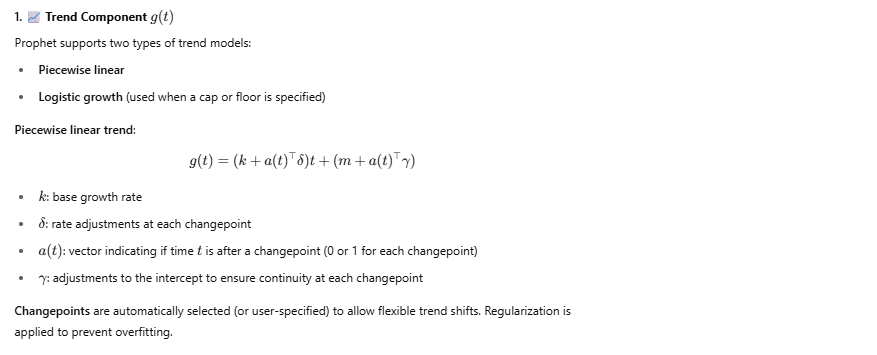

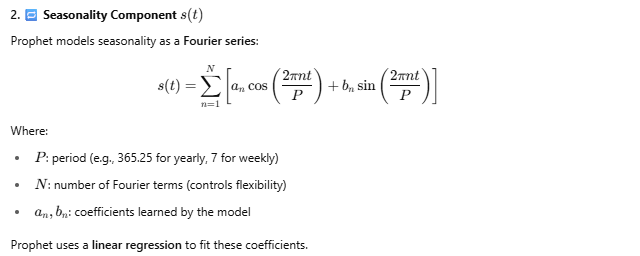

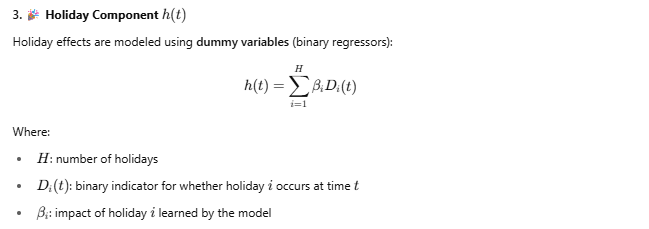

**Forecasting for Store Id - 1**

In [112]:
# for store id = 1
df_store_1 = df[df['Store_id'] == 1]

# splitting the data 
df_train = df_store_1[df_store_1['Date'] < '2019-1-1'].copy() # 12 months / 1 year 
df_val = df_store_1[(df_store_1['Date'] >= '2019-1-1')&(df_store_1['Date'] < '2019-4-1')].copy() # last 3 months before test data
df_test = df_store_1[df_store_1['Date'] >= '2019-4-1'].copy() # last 2 months of the data

df_train.head()

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,orders_per_day,sales_per_day,day_of_week,quarter,month,day,avg_order_value
0,T1000001,1,S1,L3,R1,2018-01-01,1,1,9,7011.84,Monday,1,1,1,779.0
607,T1000608,1,S1,L3,R1,2018-01-02,0,1,60,42369.00,Tuesday,1,1,2,706.0
1046,T1001047,1,S1,L3,R1,2018-01-03,0,1,72,50037.00,Wednesday,1,1,3,695.0
1207,T1001208,1,S1,L3,R1,2018-01-04,0,1,64,44397.00,Thursday,1,1,4,694.0
1752,T1001753,1,S1,L3,R1,2018-01-05,0,1,63,47604.00,Friday,1,1,5,756.0


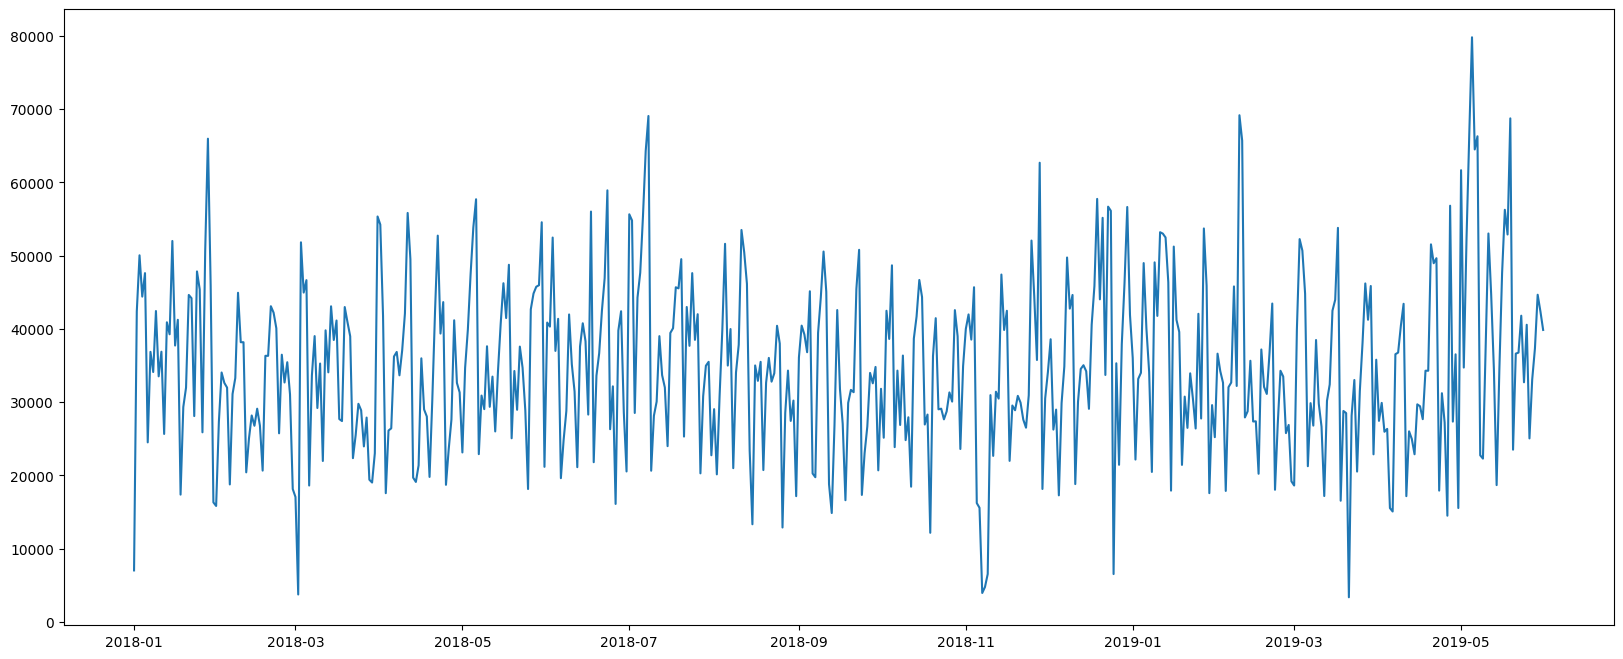

In [27]:
plt.figure(figsize = (20,8))
plt.plot(df_store_1['Date'], df_store_1['sales_per_day'])
plt.show()

**Base Model**

15:05:52 - cmdstanpy - INFO - Chain [1] start processing
15:05:52 - cmdstanpy - INFO - Chain [1] done processing


            ds          yhat    yhat_lower    yhat_upper
450 2019-03-27  33537.610108  19279.600487  48017.404733
451 2019-03-28  32057.990032  18038.678851  45243.700107
452 2019-03-29  31951.982763  19165.935885  46228.762186
453 2019-03-30  36959.108354  23313.680959  51116.671456
454 2019-03-31  39179.359434  25395.448665  52499.705557


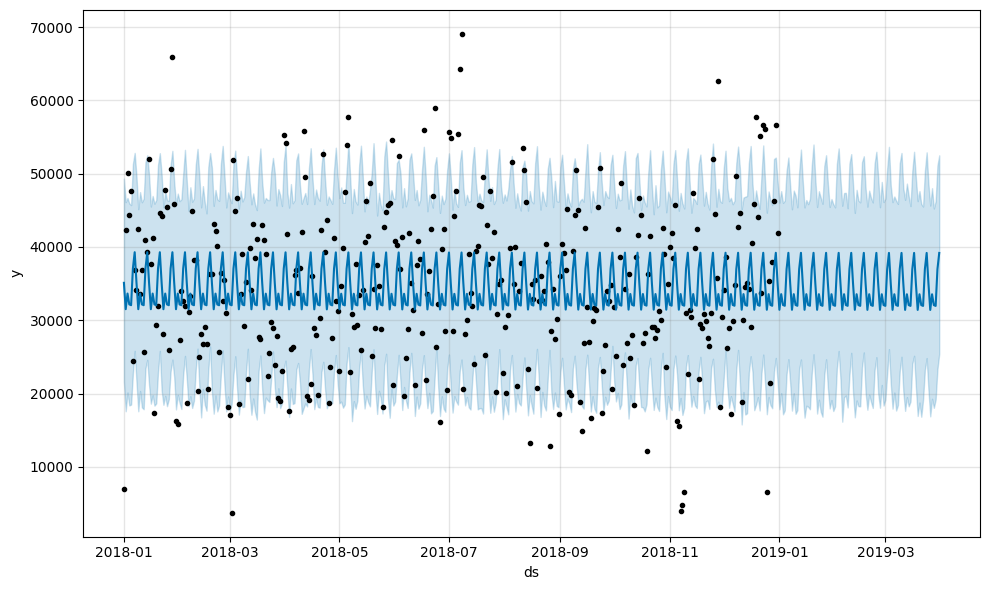

In [58]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_percentage_error

df_prophet_train = df_train[['Date','sales_per_day']]
df_prophet_train = df_prophet_train.rename(columns = {'Date':'ds','sales_per_day':'y'})
df_prophet_train.head(3)

m = Prophet()
m.fit(df_prophet_train)

future = m.make_future_dataframe(periods = len(df_val))

forecast = m.predict(future)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

fig = m.plot(forecast)

In [69]:
forecast_val = forecast[(forecast['ds'] >= df_val['Date'].min()) & (forecast['ds'] <= df_val['Date'].max())]

mape = mean_absolute_percentage_error(df_val['sales_per_day'], forecast_val['yhat']) * 100
print(f'MAPE ---> {round(mape)}%')

MAPE ---> 37%


***MAPE ---> 37%***

**Tuning Trend component**

It has following parameters:

1. ***growth***: 'linear' or 'logistic'
2. ***n_changepoints***: number of potential changepoints in the trend 
3. ***changepoint_prior_scale***: controls the flexibility of the trend at changepoints
4. ***changepoints***: manual specification of changepoint dates

15:25:09 - cmdstanpy - INFO - Chain [1] start processing
15:25:09 - cmdstanpy - INFO - Chain [1] done processing
15:25:09 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
15:25:09 - cmdstanpy - INFO - Chain [1] start processing
15:25:09 - cmdstanpy - INFO - Chain [1] done processing


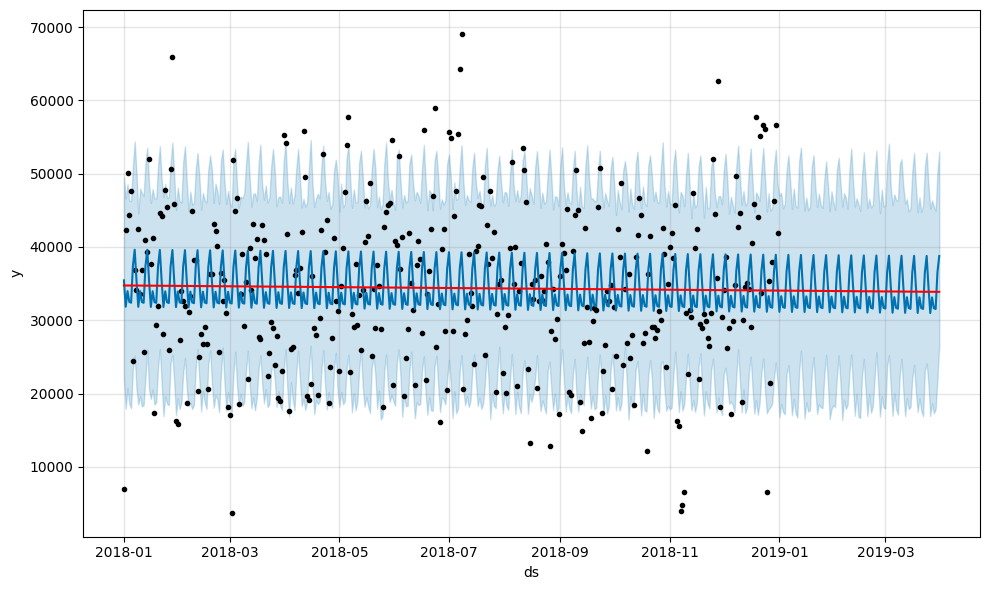

In [79]:
m = Prophet(growth='linear', n_changepoints = 0, changepoint_prior_scale=0.1)
m.fit(df_prophet_train)

future = m.make_future_dataframe(periods = len(df_val))
forecast = m.predict(future)

from prophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

**NOTE:**

1. Since it is a stationary series, ***n_changepoints*** is set to ***zero***
2. MAPE is still ---> ***37%***

**Tuning Seasonal component**

It has following parameters:

1. ***seasonality_mode:*** 'additive' or 'multiplicative'
2. ***weekly_seasonality / daily_seasonality / yearly_seasonality:*** True ---> Enable Prophet's default Fourier seasonality for that frequency. int ---> Use a custom Fourier order ( No. of harmonics ) 
3. ***seasonality_prior_scale:*** Controls the flexibility of seasonal fit
4. ***add_seasonality:*** For custom seasonalities

16:27:50 - cmdstanpy - INFO - Chain [1] start processing
16:27:50 - cmdstanpy - INFO - Chain [1] done processing
16:27:50 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:27:50 - cmdstanpy - INFO - Chain [1] start processing
16:27:51 - cmdstanpy - INFO - Chain [1] done processing


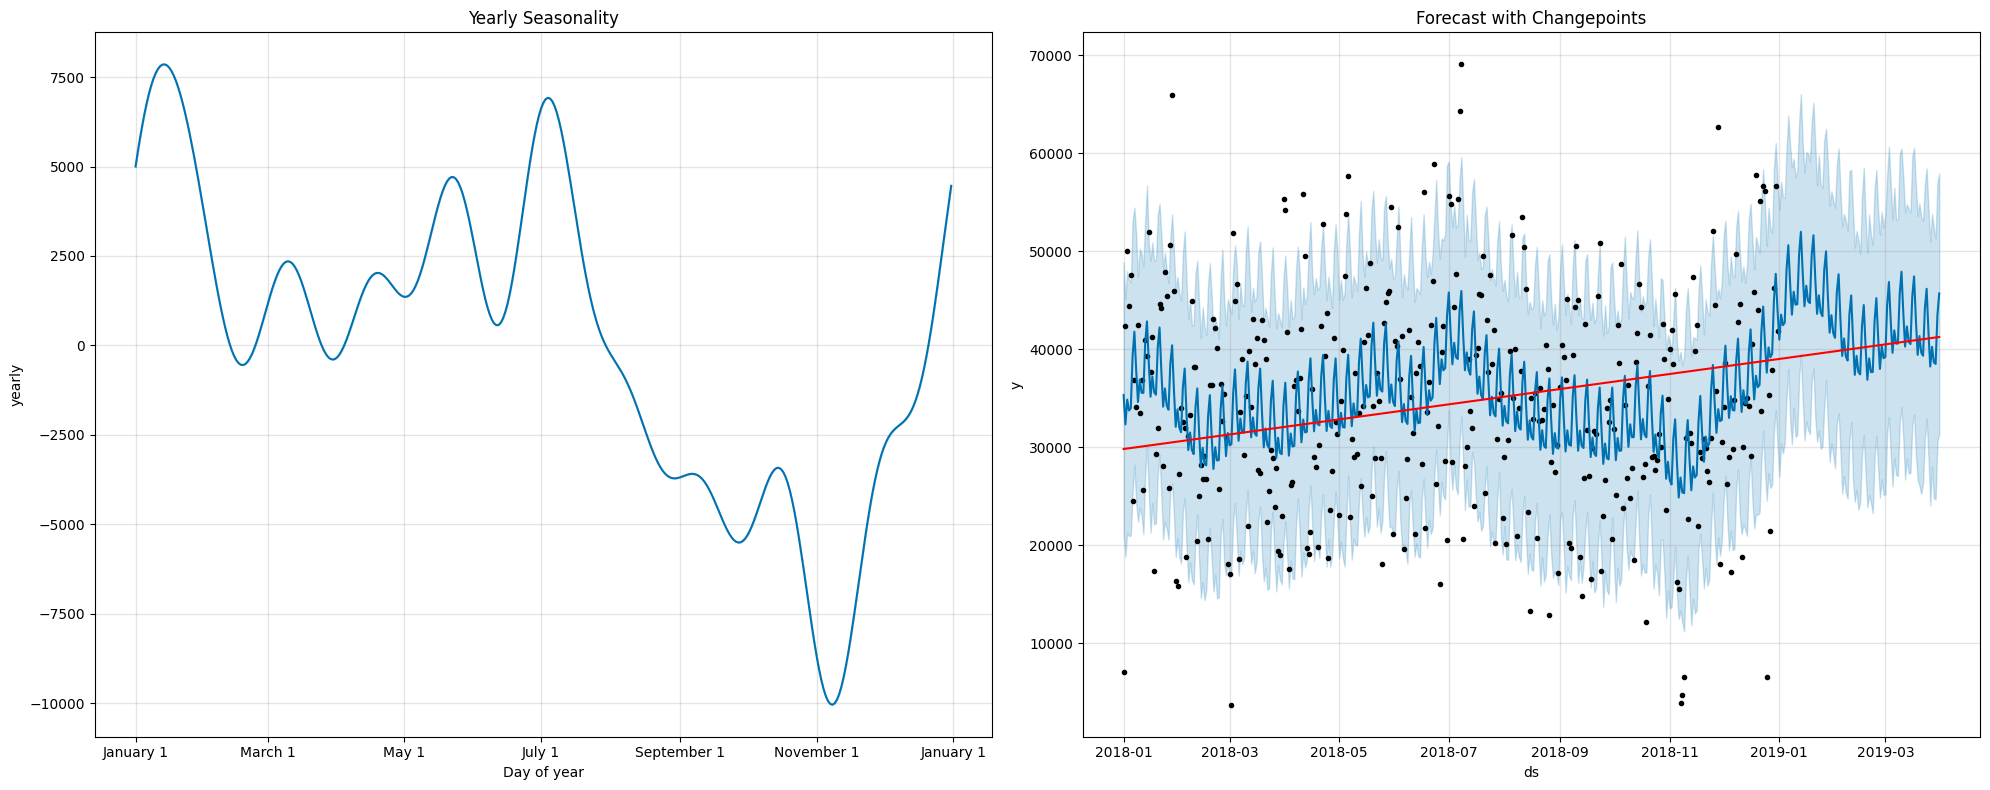

In [95]:
from prophet.plot import plot_yearly, add_changepoints_to_plot
from prophet import Prophet
import matplotlib.pyplot as plt

# Fit the model
m = Prophet(growth='linear', n_changepoints=0, changepoint_prior_scale=0.1, yearly_seasonality=10, seasonality_prior_scale = 10) # default values
m.fit(df_prophet_train)

# Make predictions
future = m.make_future_dataframe(periods=len(df_val))
forecast = m.predict(future)

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Yearly component on the left subplot
plot_yearly(m, ax=axes[0])
axes[0].set_title('Yearly Seasonality')

# Forecast plot on the right subplot
fig2 = m.plot(forecast, ax=axes[1])
add_changepoints_to_plot(axes[1], m, forecast)
axes[1].set_title('Forecast with Changepoints')

plt.tight_layout()
plt.show()

In [96]:
forecast_val = forecast[(forecast['ds'] >= df_val['Date'].min()) & (forecast['ds'] <= df_val['Date'].max())]

mape = mean_absolute_percentage_error(df_val['sales_per_day'], forecast_val['yhat']) * 100
print(f'MAPE ---> {round(mape)}%')

MAPE ---> 54%


***MAPE ---> 54%***

**GridSearch to find the best fourier order & regularization strength**

In [132]:
# Weekly seasonality

from itertools import product
from sklearn.metrics import mean_absolute_percentage_error

fourier_order = [3,7,10, 12, 14, 18, 21]
regularization_strength = [0.01, 0.1, 0.5, 0.8, 1, 3, 5, 10]

result = []

for fs, reg in product(fourier_order, regularization_strength):
    m = Prophet(n_changepoints = 0, weekly_seasonality = False, seasonality_prior_scale = reg)
    m.add_seasonality(name = 'Weekly', period = 7, fourier_order = fs)
    m.fit(df_prophet_train)
    
    future = m.make_future_dataframe(periods = len(df_val))

    forecast = m.predict(future)
    forecast_val = forecast[(forecast['ds'] >= df_val['Date'].min()) & (forecast['ds'] <= df_val['Date'].max())]
    mape = mean_absolute_percentage_error(df_val['sales_per_day'], forecast_val['yhat'])
    result.append([fs, reg, mape])

result_df = pd.DataFrame(result)
result_df.columns = ['Fourier_order', 'Regularization_strength', 'MAPE']


19:16:16 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:16:16 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:16:17 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:16:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:16:19 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:16:19 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:16:20 - cmdstanpy - ERROR - Chain [1] error: error during pro

In [133]:
result_df.sort_values( by = 'MAPE').head()

,Fourier_order,Regularization_strength,MAPE
33,14,0.1,0.358515
47,18,10.0,0.368387
18,10,0.5,0.368511
54,21,5.0,0.368730
2,3,0.5,0.368759


In [134]:
# Monthly seasonality

from itertools import product
from sklearn.metrics import mean_absolute_percentage_error

fourier_order = [3,7,10, 12, 14, 18, 21]
regularization_strength = [0.01, 0.1, 0.5, 0.8, 1, 3, 5, 10]

result = []

for fs, reg in product(fourier_order, regularization_strength):
    m = Prophet(n_changepoints = 0, weekly_seasonality = False, seasonality_prior_scale = reg)
    m.add_seasonality(name = 'Weekly', period = 30.5, fourier_order = fs)
    m.fit(df_prophet_train)
    
    future = m.make_future_dataframe(periods = len(df_val))

    forecast = m.predict(future)
    forecast_val = forecast[(forecast['ds'] >= df_val['Date'].min()) & (forecast['ds'] <= df_val['Date'].max())]
    mape = mean_absolute_percentage_error(df_val['sales_per_day'], forecast_val['yhat'])
    result.append([fs, reg, mape])

result_df = pd.DataFrame(result)
result_df.columns = ['Fourier_order', 'Regularization_strength', 'MAPE']


19:17:08 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:17:09 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:17:11 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:17:14 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:17:16 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:17:17 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:17:19 - cmdstanpy - ERROR - Chain [1] error: error during pro

In [135]:
result_df.sort_values( by = 'MAPE').head()

,Fourier_order,Regularization_strength,MAPE
0,3,0.01,0.384123
1,3,0.10,0.387016
7,3,10.00,0.387017
6,3,5.00,0.387019
5,3,3.00,0.387019


In [136]:
# Yearly seasonality

from itertools import product
from sklearn.metrics import mean_absolute_percentage_error

fourier_order = [3,7,10, 12, 14, 18, 21]
regularization_strength = [0.01, 0.1, 0.5, 0.8, 1, 3, 5, 10]

result = []

for fs, reg in product(fourier_order, regularization_strength):
    m = Prophet(n_changepoints = 0, weekly_seasonality = False, seasonality_prior_scale = reg)
    m.add_seasonality(name = 'Weekly', period = 365, fourier_order = fs)
    m.fit(df_prophet_train)
    
    future = m.make_future_dataframe(periods = len(df_val))

    forecast = m.predict(future)
    forecast_val = forecast[(forecast['ds'] >= df_val['Date'].min()) & (forecast['ds'] <= df_val['Date'].max())]
    mape = mean_absolute_percentage_error(df_val['sales_per_day'], forecast_val['yhat'])
    result.append([fs, reg, mape])

result_df = pd.DataFrame(result)
result_df.columns = ['Fourier_order', 'Regularization_strength', 'MAPE']

19:17:55 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:17:55 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:17:56 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:17:56 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:17:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:17:58 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:17:58 - cmdstanpy - ERROR - Chain [1] error: error during pro

In [137]:
result_df.sort_values( by = 'MAPE').head()

,Fourier_order,Regularization_strength,MAPE
32,14,0.01,0.372612
24,12,0.01,0.376000
33,14,0.10,0.378500
16,10,0.01,0.379541
40,18,0.01,0.379556


**NOTE:**

Best MAPE for different seasonalities:

1. Weekly seasonality: n - 14, regularization - 0.1 ---> ***MAPE - 35.8%***
2. Monthly seasonality: n - 3, regularization - 0.01 ---> ***MAPE - 38.4%***
3. Yearly seasonality: n - 14, regularization - 0.01 ---> ***MAPE - 37.2%***

21:02:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.


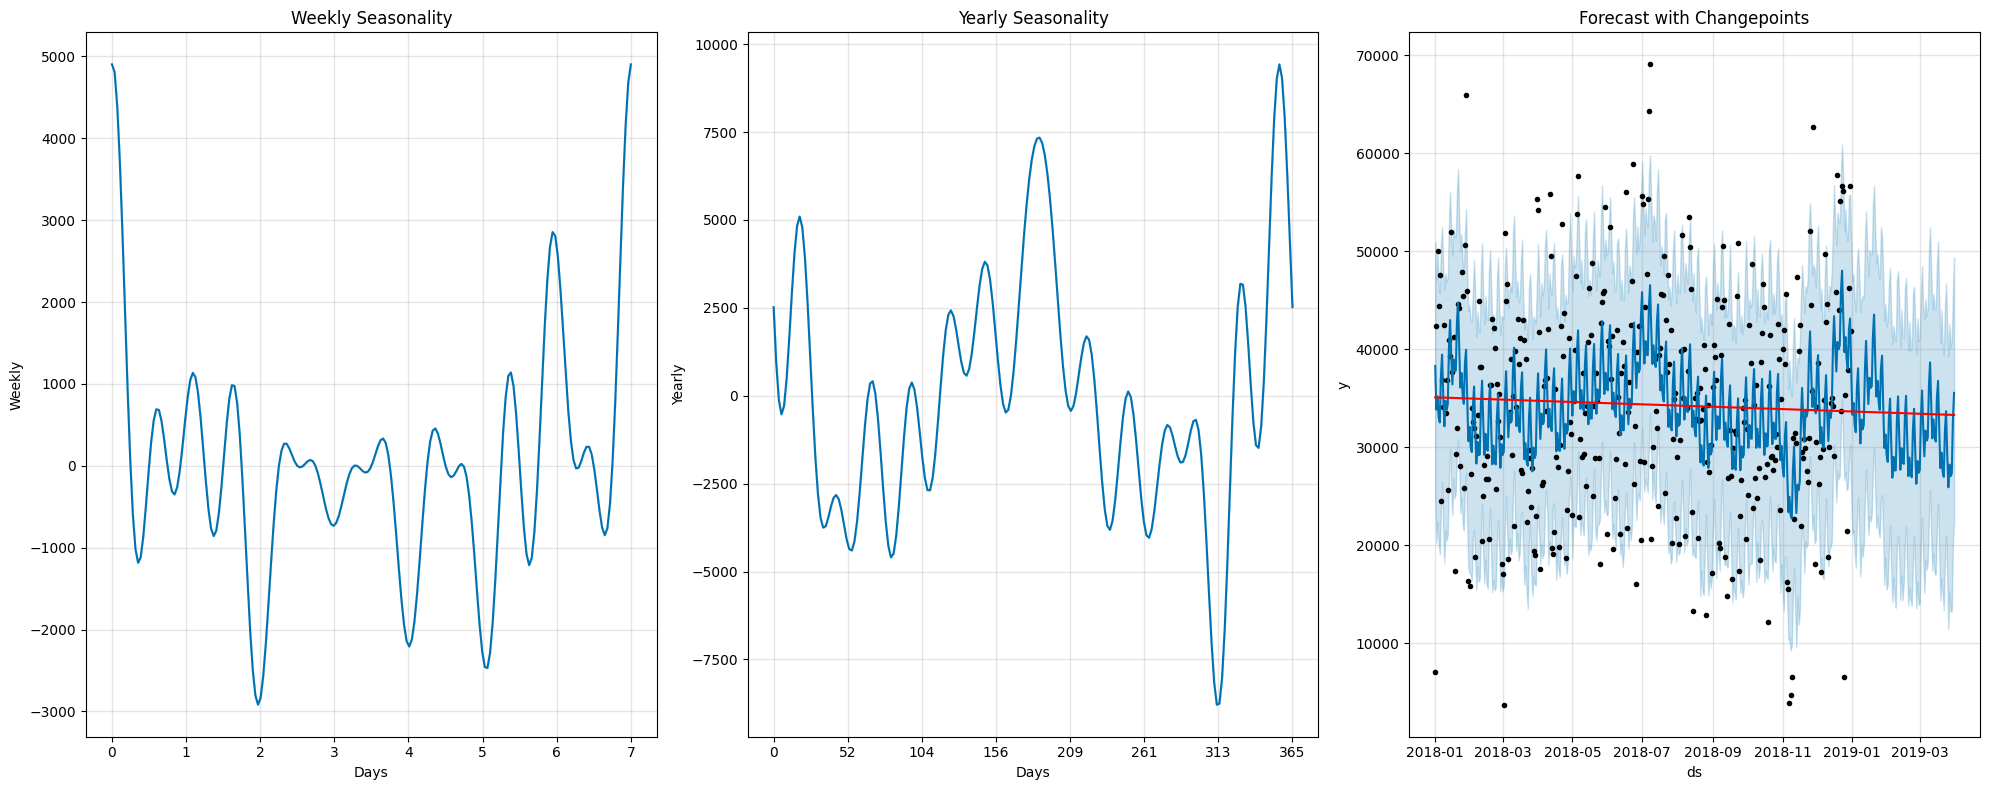

In [164]:
from prophet.plot import plot_yearly, add_changepoints_to_plot, plot_seasonality
from prophet import Prophet
import matplotlib.pyplot as plt

# Fit the model
m = Prophet(n_changepoints = 0, weekly_seasonality = False, seasonality_prior_scale = 0.1)
m.add_seasonality(name = 'Weekly', period = 7, fourier_order = 14)
m.add_seasonality(name = 'Yearly', period = 365, fourier_order = 14)
m.fit(df_prophet_train)

# Make predictions
future = m.make_future_dataframe(periods=len(df_val))
forecast = m.predict(future)

# Create side-by-side plots
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

# Yearly component on the left subplot
plot_seasonality(m, name = 'Weekly', ax=axes[0]) 
axes[0].set_title('Weekly Seasonality')

plot_seasonality(m, name='Yearly', ax=axes[1])
axes[1].set_title("Yearly Seasonality")

# Forecast plot on the right subplot
fig2 = m.plot(forecast, ax=axes[2])
add_changepoints_to_plot(axes[2], m, forecast)
axes[2].set_title('Forecast with Changepoints')

plt.tight_layout()
plt.show()

In [162]:
forecast_val = forecast[(forecast['ds'] >= df_val['Date'].min()) & (forecast['ds'] <= df_val['Date'].max())]

mape = mean_absolute_percentage_error(df_val['sales_per_day'], forecast_val['yhat']) * 100
print(f'MAPE ---> {round(mape)}%')

MAPE ---> 34%


**NOTE:**

1. ***MAPE ---> 34%***
2. MAPE has improved from ***35.8% ---> 34%*** when ***weekly & yearly seasonalities are combined***

**Tuning Holiday component**

# Practise

In [1]:
# for store id = 1
df_store_1 = df[df['Store_id'] == 1]

# splitting the data 
df_train = df_store_1[df_store_1['Date'] < '2019-1-1'].copy() # 12 months / 1 year 
df_val = df_store_1[(df_store_1['Date'] >= '2019-1-1')&(df_store_1['Date'] < '2019-4-1')].copy() # last 3 months before test data
df_test = df_store_1[df_store_1['Date'] >= '2019-4-1'].copy() # last 2 months of the data

df_train.head()

NameError: name 'df' is not defined

In [ ]:
plt.figure(figsize = (20,8))
plt.plot(df_store_1['Date'], df_store_1['sales_per_day'])
plt.show()

# Outcome

Accurate forecasting of sales has 3 major benefits:

1. Accurate production levels
2. Reduced logistic costs
3. Optimized Inventory space

**Recommendations:**

1. Production Planning Buffer

    * Since the worst-case MAPE observed is ***9.62%***, production teams should plan for up to ±10% variation in forecasted sales
    * This buffer helps absorb forecast uncertainty while avoiding overproduction or underproduction

2. Inventory Space Allocation

    * Warehousing capacity should be flexible enough to accommodate up to ***10%*** more stock than predicted
    * Similarly, lean inventory strategies should be adjusted to avoid stockouts if actual demand exceeds forecasts by ***~10%***

3. 